## PET Reconstruction Combination of KEM and DIP
- load all Libaries and create DIP repository from git to use the skip function
- for first time installing in jupyter notebook use "!pip install" 

In [2]:
#!pip install SimpleITK
#!pip install scikit-image
#!pip install numpy
#!pip install matplotlib
#!pip install torch
#!pip install opencv-python
#!pip install torchmetrics
#!pip install seaborn

In [3]:
# load libaries
import os
import SimpleITK as sitk
from skimage.transform import radon, iradon
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch
import torch.nn as nn
from torch.optim import Adam
from scipy.ndimage import rotate
import cv2
from skimage.restoration import denoise_tv_chambolle
import torch.nn.functional as F
import matplotlib.image as mpimg
import torch.optim as optim
from torchmetrics.image import StructuralSimilarityIndexMeasure


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import the DIP repository, make sure to clone https://github.com/DmitryUlyanov/deep-image-prior
import sys
sys.path.append('C:/Users/Administrator/deep-image-prior')
from models import skip

**Helper Functions**
- generate sinogram with ground truth and angles
- add poisson noise to a sinogram
- backprojection

In [4]:
def generate_sinogram_2d(image_2d, angles):
    # Get image dimensions
    rows, cols = image_2d.shape
    # Calculate the radius of the circle
    radius = min(rows, cols) // 2
    # Create a mask to zero out areas outside the circle
    Y, X = np.ogrid[:rows, :cols]
    center_y, center_x = rows / 2, cols / 2
    mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
    image_masked = image_2d * mask
    # Generate sinogram
    sinogram = radon(image_masked, theta=angles, circle=True)
    return sinogram


def add_poisson_noise(sinogram, scale=0.0001): 
    # Ensure there are no negative values (Poisson noise requires non-negative input)
    sinogram_clipped = np.clip(sinogram, 0, None)
    
    # Scale up the intensity values to approximate "photon counts"
    # small number increases the noise
    sinogram_scaled = sinogram_clipped * scale
    
    # Generate Poisson noise (random photon counts)
    sinogram_noisy_scaled = np.random.poisson(sinogram_scaled).astype(np.float32)
    
    # Scale back down to the original magnitude
    sinogram_noisy = sinogram_noisy_scaled / scale
    return sinogram_noisy


def backproject(sinogram, angles):
    reconstructed = np.zeros((sinogram.shape[1], sinogram.shape[1]))
    for i, angle in enumerate(angles):
        rotated_projection = rotate(np.tile(sinogram[i], (sinogram.shape[1], 1)).T, -angle, reshape=False)
        reconstructed += rotated_projection
    return reconstructed / len(angles)


def generate_sinogram(image, num_angles=180):
    angles = np.linspace(0, 180, num_angles, endpoint=False)
    sinogram = np.array([np.sum(rotate(image, angle, reshape=False), axis=0) for angle in angles])
    return sinogram, angles


def project(image, angles):
    return radon(image, theta=angles, circle=True)


def backproject(sinogram, angles):
    if isinstance(sinogram, torch.Tensor):
        sinogram = sinogram.cpu().numpy()
    return iradon(sinogram, theta=angles, circle=True)


**MLEM Formula**
The MLEM algorithm iteratively updates the reconstructed image by maximizing the likelihood of the measured sinogram data given the estimated projections.

$$
f_{k+1}(x,y) = f_k(x,y) \cdot \frac{\sum_{\theta} \sum_{s} \frac{P_{\theta,s}(x,y) \cdot g_{\theta,s}}{\sum_{x',y'} P_{\theta,s}(x',y') f_k(x',y')}}{\sum_{\theta} \sum_{s} P_{\theta,s}(x,y)}
$$

where:
- \( f_k(x,y) \) is the reconstructed image at iteration \( k \)
- \( g_{\theta,s} \) is the measured projection at angle \( \theta \) and detector position \( s \) (sinogram value)
- \( P_{\theta,s}(x,y) \) is the probability of a photon from \( (x,y) \) contributing to bin \( (\theta,s) \) (i.e., the system matrix)
- The numerator represents backprojection of the ratio between measured and estimated projections
- The denominator normalizes by the sum of projection probabilities

Steps
1. Initialize the image \( f_0(x,y) \) with ones.
2. Compute the system matrix \( P_{\theta,s}(x,y) \) by forward-projecting a uniform image.
3. Iterate the following updates for \( k = 1,2, \dots, N \):
   - Forward project the current estimate to obtain estimated projections.
   - Compute the ratio between measured and estimated projections.
   - Backproject the ratio.
   - Update the image using the MLEM equation.
   - Ensure non-negative values (clip to 0 if necessary).
4. Stop when convergence is reached (or after a set number of iterations).

In [5]:
def MLEM_reconstruction(sinogram, angles, reference_image, num_iterations=50):
    # Initialize the image with ones
    image_shape = (sinogram.shape[1], sinogram.shape[1])
    reconstructed = np.ones(image_shape, dtype=np.float32)
    
    psnr_values = []
    ssim_values = []
    epsilon = 1e-6

    for iteration in range(num_iterations):
        # E-Step: Forward projection
        forward_projection = radon(reconstructed, theta=angles, circle=True)
        
        # Ensure matching shapes for division
        if forward_projection.shape != sinogram.shape:
            forward_projection = forward_projection[: sinogram.shape[0], :]

        # Compute the ratio
        ratio = sinogram / (forward_projection + epsilon)

        # M-Step: Backprojection of the ratio
        back_projection = iradon(ratio, theta=angles, filter_name=None, circle=True)

        # Update the reconstructed image
        reconstructed *= back_projection

        # Regularization to ensure non-negative image
        reconstructed = np.maximum(reconstructed, 0)

        # Compute PSNR
        psnr_value = cv2.PSNR(reference_image.astype(np.float32), reconstructed.astype(np.float32))
        psnr_values.append(psnr_value)

        # Compute SSIM
        ssim_value = ssim(reference_image, reconstructed, data_range=reference_image.max() - reference_image.min())
        ssim_values.append(ssim_value)

    # Find optimal iterations for PSNR and SSIM
    opti_psnr_iter = np.argmax(psnr_values) + 1  # Convert 0-based index to 1-based
    opti_ssim_iter = np.argmax(ssim_values) + 1

    return reconstructed, psnr_values, ssim_values, opti_psnr_iter, opti_ssim_iter

**DICOM Reader and Image Registration for PET and CT Images**

In [6]:
## Dicom reader
def load_dicom_series(folder_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(folder_path)
    if not dicom_names:
        raise ValueError(f"No DICOM files found in {folder_path}")
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

def normalize_image(image):
    img_array = sitk.GetArrayFromImage(image).astype(np.float32)
    img_min = np.min(img_array)
    img_max = np.max(img_array)
    if img_max - img_min < 1e-5:
        return np.zeros_like(img_array)
    else:
        return (img_array - img_min) / (img_max - img_min)

In [7]:
## Image registration
def register_pet_ct(ct_image, pet_image, mode="upsample_PET"):
    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()

    # Set multi-resolution pyramid strategy
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Set registration metric
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    # Set transformation type (rigid transformation)
    initial_transform = sitk.CenteredTransformInitializer(
        ct_image,
        pet_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Set optimizer
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0,
                                                      numberOfIterations=100,
                                                      convergenceMinimumValue=1e-6,
                                                      convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Set interpolation method
    registration_method.SetInterpolator(sitk.sitkLinear)

    try:
        final_transform = registration_method.Execute(sitk.Cast(ct_image, sitk.sitkFloat32),
                                                      sitk.Cast(pet_image, sitk.sitkFloat32))
        print("Optimizer Converged:", registration_method.GetOptimizerStopConditionDescription())
        print("Final Metric Value:", registration_method.GetMetricValue())
    except Exception as e:
        print(f"\nRegistration failed: {e}")
        raise e

    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(final_transform)

    if mode == "upsample_PET":
        resampler.SetReferenceImage(ct_image)
        pet_resampled = resampler.Execute(pet_image)
        print("Resampling completed.")
        return ct_image, pet_resampled

    elif mode == "downsample_CT":
        resampler.SetReferenceImage(pet_image)
        ct_resampled = resampler.Execute(ct_image)
        print("Resampling completed.")
        return ct_resampled, pet_image

    else:
        raise ValueError("Invalid mode selection, mode should be 'upsample_PET' or 'downsample_CT'")

**Kernelized Expectation Maximization (KEM) with Bowsher Prior**
Kernelized Expectation Maximization (KEM) extends MLEM by incorporating prior knowledge through an anatomical kernel, 

improving noise reduction and preserving edges.

$$
f_{k+1}(x,y) = f_k(x,y) \cdot \frac{\sum_{\theta} \sum_{s} \frac{P_{\theta,s}(x,y) \cdot g_{\theta,s}}{\sum_{x',y'} P_{\theta,s}(x',y') f_k(x',y')}}{\sum_{\theta} \sum_{s} P_{\theta,s}(x,y)}
$$

where:
- \( f_k(x,y) \) is the estimated image at iteration \( k \)
- \( g_{\theta,s} \) is the measured sinogram value at projection angle \( \theta \) and detector position \( s \)
- \( P_{\theta,s}(x,y) \) is the system matrix representing the probability of a photon from \( (x,y) \) contributing to bin \( (\theta,s) \)
- The fraction represents ratio between measured and estimated projections, which is backprojected to update the image

The main difference from standard MLEM is the kernel-based filtering step, which integrates additional prior information:

$$
f_{k+1}(x,y) = K(x,y) \cdot f_{k+1}(x,y)
$$

where \( K(x,y) \) is the anatomical kernel matrix, derived from structural information (here CT), guiding the reconstruction towards anatomically plausible regions.

**Bowsher Prior** 
This is a spatially adaptive filter that selects a set of neighbors based on similarity in an auxiliary anatomical image.

$$
K(x,y) = \sum_{j \in N(x,y)} w_j f_j
$$

where:
- \( N(x,y) \) represents a set of nearest neighbors selected based on anatomical similarity
- \( w_j \) are weights derived from intensity similarity in the auxiliary image
- \( f_j \) are neighboring pixel values from the current reconstruction

**KEM Algorithm Steps**
1. Initialize the image \( f_0(x,y) \) with ones
2. Compute the system matrix \( P_{\theta,s}(x,y) \) by forward-projecting a uniform image
3. Construct the anatomical kernel \( K(x,y) \) using the auxiliary image
4. Iterate the following updates for \( k = 1,2, ... N \):
   - Forward project the current estimate to obtain estimated projections
   - Compute the ratio between measured and estimated projections
   - Backproject the ratio
   - Apply kernel filtering using the Bowsher Prior
   - Update the image using the KEM equation
   - Ensure non-negative values with clip to 0
5. Stop after a set number of iterations is reached


In [8]:
# Design for Bowsher prior Filter 
def apply_bayesian_filter(image_2d, sigma=1.0, zeta=0.5, rho=0.01, alpha=0.001):
    # Compute the Bayesian kernel (Bowsher-like prior)
    kernel = compute_bowsher_kernel_2d(image_2d, zeta=zeta, rho=rho, alpha=alpha)
    filtered_image = image_2d * kernel
    return filtered_image

def compute_kernel_2d(ct_2d, sigma=1.0):
    # Compute the gradient of the CT image
    gradient_x = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_y = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # Design a bilateral kernel, assigning lower weights to edges
    kernel = np.exp(- (gradient_magnitude ** 2))
    return kernel

def psi(u, zeta=0.5, rho=0.01):
    return (np.arctan((zeta - u) / rho) / np.pi) + 0.5

def Tq_linear(value):
    return value

def compute_bowsher_kernel_2d(
    ct_image_2d, 
    zeta=0.5, 
    rho=0.01, 
    Tq_func=Tq_linear, 
    epsilon=1e-6,
    alpha = 0.001
):
    # Offsets for the 8 neighbors in (dy, dx)
    neighbor_offsets = [
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1),          ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1)
    ]
    
    H, W = ct_image_2d.shape
    weights_2d = np.zeros((H, W, len(neighbor_offsets)), dtype=np.float32)

    # Pre-compute Tq for the entire image to avoid repeated calls
    transformed_ct = Tq_func(ct_image_2d)

    # For each pixel, we need M_j = max|Tq(mu_j) - Tq(mu_k)| over neighbors
    M_array = np.zeros((H, W), dtype=np.float32)

    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            diffs = []
            for dy, dx in neighbor_offsets:
                ny, nx = y + dy, x + dx
                if 0 <= ny < H and 0 <= nx < W:
                    neighbor_val = transformed_ct[ny, nx]
                    diffs.append(abs(central_val - neighbor_val))
            if len(diffs) > 0:
                M_array[y, x] = max(diffs)
            else:
                M_array[y, x] = 0.0

    # Compute the actual weights for each neighbor
    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            Mj = M_array[y, x]
            
            for n_idx, (dy, dx) in enumerate(neighbor_offsets):
                ny, nx = y + dy, x + dx
                if not (0 <= ny < H and 0 <= nx < W):
                    # Out of bounds, weight = 0
                    weights_2d[y, x, n_idx] = 0.0
                    continue
                
                neighbor_val = transformed_ct[ny, nx]
                Mk = M_array[ny, nx]
                
                denom = (Mj + Mk) / 2.0
                denom = denom if denom > epsilon else epsilon
                
                diff = abs(central_val - neighbor_val)
                u_jk = diff / denom
                
                w_jk = psi(u_jk, zeta=zeta, rho=rho)
                weights_2d[y, x, n_idx] = w_jk

    kernel = np.sum(weights_2d, axis=-1)
    kernel = np.exp(alpha * kernel) 
    return kernel

**Helper Functions to create the Hybrid Reconstruction with different Filter Options**

- Bilateral: Edge-preserving smoothing (reduces noise without blurring edges)
- Anisotropic: Noise reduction while preserving sharp edges
- Gaussian: General smoothing and noise removal
- Bayesian: Denoising with probabilistic framework using prior knowledge
- Gradient (with CT prior): Adaptive smoothing with anatomical guidance from prior images

In [9]:
def apply_filter(image, method="bilateral", sigma=1.0, zeta=0.5, rho=0.01, alpha=0.001, ct_prior=None):

    image_np = image.detach().cpu().numpy() 

    if method == "bilateral":
        filtered_image = cv2.bilateralFilter(image_np.astype(np.float32), d=9, sigmaColor=sigma*50, sigmaSpace=sigma*50)
    
    elif method == "anisotropic":
        filtered_image = denoise_tv_chambolle(image_np, weight=sigma)
    
    elif method == "gaussian":
        filtered_image = gaussian_filter(image_np, sigma=sigma)
    
    elif method == "bayesian":
        filtered_image = apply_bayesian_filter(image_np, sigma=sigma, zeta=zeta, rho=rho, alpha=alpha)
    
    elif method == "gradient":
        if ct_prior is None:
            raise ValueError("CT prior required for gradient-based kernel filtering.")

        # Precompute the anatomical kernel
        if ct_prior is not None:
            if isinstance(ct_prior, torch.Tensor):
                ct_prior_np = ct_prior.squeeze().detach().cpu().numpy()
            else:
                ct_prior_np = ct_prior  # Already a NumPy array, no need to convert

            kernel = compute_kernel_2d(ct_prior_np, sigma=sigma)


        #ct_prior_np = ct_prior.squeeze().detach().cpu().numpy()
        #kernel = compute_kernel_2d(ct_prior_np, sigma=sigma)  # Compute anatomical gradient kernel
        filtered_image = image_np * kernel  # Weight input image by anatomical kernel

    else:
        raise ValueError("Invalid method. Choose 'bilateral', 'anisotropic', 'gaussian', 'bayesian', or 'gradient'.")

    return torch.tensor(filtered_image, dtype=torch.float32).to(image.device)

**KEM Reconstruction** 
- with different filter options
- try different number of iterations
- returns psnr value to find optimum
- return optimum for SSIM iter 
- return optimum for PSNR iter

In [10]:
def run_KEM_reconstruction(sinogram, angles, ground_truth, ct_prior, filter_method="bayesian", num_iterations=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    image_shape = (sinogram.shape[1], sinogram.shape[1]) 
    reconstructed = torch.ones(image_shape, dtype=torch.float32, device=device)

    psnr_values = []
    ssim_values = []

    # Convert sinogram to torch tensor
    sinogram_torch = torch.tensor(sinogram, dtype=torch.float32, device=device)

    for i in range(1, num_iterations + 1):
        forward_projection = torch.tensor(radon(reconstructed.cpu().numpy(), theta=angles, circle=True), dtype=torch.float32, device=device)
        ratio = sinogram_torch / (forward_projection + 1e-6)
        
        back_projection_np = iradon(ratio.cpu().numpy(), theta=angles, filter_name=None, circle=True)
        back_projection = torch.tensor(back_projection_np, dtype=torch.float32, device=device)

        if filter_method is not None:
            filtered_image = apply_filter(reconstructed, method=filter_method, sigma=1, ct_prior=ct_prior)
        else:
            filtered_image = back_projection  # No filtering

        reconstructed = back_projection * filtered_image
        reconstructed = torch.clamp(reconstructed, min=0)  # Ensure non-negative values

        # Compute PSNR
        psnr_value = psnr(ground_truth, reconstructed.cpu().numpy(), data_range=ground_truth.max() - ground_truth.min())
        psnr_values.append(psnr_value)

        # Compute SSIM
        ssim_value = ssim(ground_truth, reconstructed.cpu().numpy(), data_range=ground_truth.max() - ground_truth.min())
        ssim_values.append(ssim_value)

        # Stop early if PSNR and SSIM start decreasing (indicating overfitting)
        if i > 5 and psnr_values[-1] < psnr_values[-2] and ssim_values[-1] < ssim_values[-2]:
            print(f"Stopping early at iteration {i-1}: PSNR and SSIM started decreasing.")
            break

    # Find optimal iteration (Peak PSNR & SSIM)
    optimal_iter_psnr = np.argmax(psnr_values) + 1  # +1 to match iteration count
    optimal_iter_ssim = np.argmax(ssim_values) + 1


    return reconstructed.cpu().numpy(), psnr_values , ssim_values, optimal_iter_psnr, optimal_iter_ssim


**Plotting Function for Reconstruction Result and Other Plots for Comparison**

In [11]:
def plot_result_and_comparison(only_kem_result, ct_prior, refined_image, mlem_reconstructed, ground_truth):
    fig, axes = plt.subplots(2, 3, figsize=(14, 10))

    im1 = axes[0, 0].imshow(only_kem_result, cmap="gray")
    axes[0, 0].set_title("Initial KEM")
    axes[0, 0].axis("off")
    fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)

    im2 = axes[0, 1].imshow(ct_prior, cmap="gray")
    axes[0, 1].set_title("CT Prior")
    axes[0, 1].axis("off")
    fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)

    im3 = axes[0, 2].imshow(refined_image, cmap="gray")
    axes[0, 2].set_title("Final Refined Image")
    axes[0, 2].axis("off")
    fig.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)

    im4 = axes[1, 0].imshow(mlem_reconstructed, cmap="gray")
    axes[1, 0].set_title("MLEM Reconstruction")
    axes[1, 0].axis("off")
    fig.colorbar(im4, ax=axes[1, 0], fraction=0.046, pad=0.04)

    im5 = axes[1, 1].imshow(ground_truth, cmap="gray")
    axes[1, 1].set_title("Ground Truth")
    axes[1, 1].axis("off")
    fig.colorbar(im5, ax=axes[1, 1], fraction=0.046, pad=0.04)

    fig.delaxes(axes[1, 2])
    plt.tight_layout()
    plt.show()

**Evaluation Function** 
- PSNR
- MSE
- SSIM
- RSME

In [12]:
# Evaluation
def evaluate_reconstruction(ground_truth, reconstructed):
    mse_val = np.mean((ground_truth - reconstructed) ** 2)  # Direct computation of MSE
    rmse_val = np.sqrt(mse_val)  # RMSE
    psnr_val = cv2.PSNR(ground_truth.astype(np.float32), reconstructed.astype(np.float32))  # PSNR
    ssim_val = ssim(ground_truth, reconstructed, data_range=ground_truth.max() - ground_truth.min())  # SSIM

    return mse_val, psnr_val, ssim_val, rmse_val

## Load functions if DICOM data is available

In [13]:
def load_images(ct_folder_path, pet_folder_path):
    # Load images
    print("Loading CT image...")
    ct_image = load_dicom_series(ct_folder_path)
    print("Loading PET image...")
    pet_image = load_dicom_series(pet_folder_path)

    # Print image information
    def print_image_info(name, image):
     print(f"\n{name} Image Information:")
     print(f"  Size: {image.GetSize()}")
     print(f"  Spacing: {image.GetSpacing()}")
     print(f"  Origin: {image.GetOrigin()}")
     print(f"  Direction: {image.GetDirection()}")
     print(f"  Dimension: {image.GetDimension()}")

    print_image_info("CT", ct_image)
    print_image_info("PET", pet_image)

    # Ensure both are 3D images
    if ct_image.GetDimension() != 3 or pet_image.GetDimension() != 3:
        raise ValueError("Both CT and PET images must be 3D.")

    # Ensure both are float32
    ct_image = sitk.Cast(ct_image, sitk.sitkFloat32)
    pet_image = sitk.Cast(pet_image, sitk.sitkFloat32)

    #mode = "upsample_PET"
    mode = "downsample_CT"
    ct_image_resampled, pet_image_resampled = register_pet_ct(ct_image, pet_image, mode=mode)

    # ================== 3) Select Middle Slice and Generate Sinogram ==================

    # Select middle slice
    ct_array = sitk.GetArrayFromImage(ct_image_resampled)  # shape: [slices, height, width]
    pet_array = sitk.GetArrayFromImage(pet_image_resampled)  # shape: [slices, height, width]

    middle_slice_idx = ct_array.shape[0] // 2
    ct_slice = ct_array[middle_slice_idx, :, :]
    pet_slice = pet_array[middle_slice_idx, :, :]

    # Normalize
    ct_norm = normalize_image(ct_image_resampled)
    pet_norm = normalize_image(pet_image_resampled)
    ct_slice_norm = ct_norm[middle_slice_idx, :, :]
    pet_slice_norm = pet_norm[middle_slice_idx, :, :]
    initial_kernel_size = ct_slice_norm

    # Generate sinogram
    angles = np.linspace(0., 180., max(ct_slice.shape), endpoint=False)
    pet_sinogram = generate_sinogram_2d(pet_slice_norm, angles)
    pet_sinogram = add_poisson_noise(pet_sinogram, scale=0.001)

    return pet_sinogram, ct_slice, ct_slice_norm, initial_kernel_size, pet_slice, pet_slice_norm, angles


**Load CT Image, PET Image and create noisy PET Sinogram from DICOM Data**

In [14]:
# Load an example image DICOM
#ct_folder_path = r"C:\Users\Administrator\OneDrive - stud.hs-mannheim.de\Dokumente\PCC3\NIH\PET\CT_1.3.6.1.4.1.14519.5.2.1.7009.2403.798861112144623421423086363370"
#pet_folder_path = r"C:\Users\Administrator\OneDrive - stud.hs-mannheim.de\Dokumente\PCC3\NIH\PET\PT_1.3.6.1.4.1.14519.5.2.1.7009.2403.291916523874874486349020167447"

#pet_sinogram, ct_slice, ct_slice_norm, initial_kernel_size, pet_slice, pet_slice_norm, angles = load_images(ct_folder_path, pet_folder_path)

#ct_prior_norm = ct_slice_norm
#ct_prior = ct_slice

#pet_slice_norm = (pet_slice - np.min(pet_slice)) / (np.max(pet_slice) - np.min(pet_slice))
#ground_truth = pet_slice_norm

## Load generated Phantom if available

In [15]:
ct_prior = cv2.imread("ct_image.png", cv2.IMREAD_GRAYSCALE).astype(np.float32)
ground_truth = cv2.imread("ground_truth.png", cv2.IMREAD_GRAYSCALE).astype(np.float32) # pet image is called ground truth

print("CT Prior Shape:", ct_prior.shape)
print("Ground Truth Shape:", ground_truth.shape)

CT Prior Shape: (128, 128)
Ground Truth Shape: (128, 128)


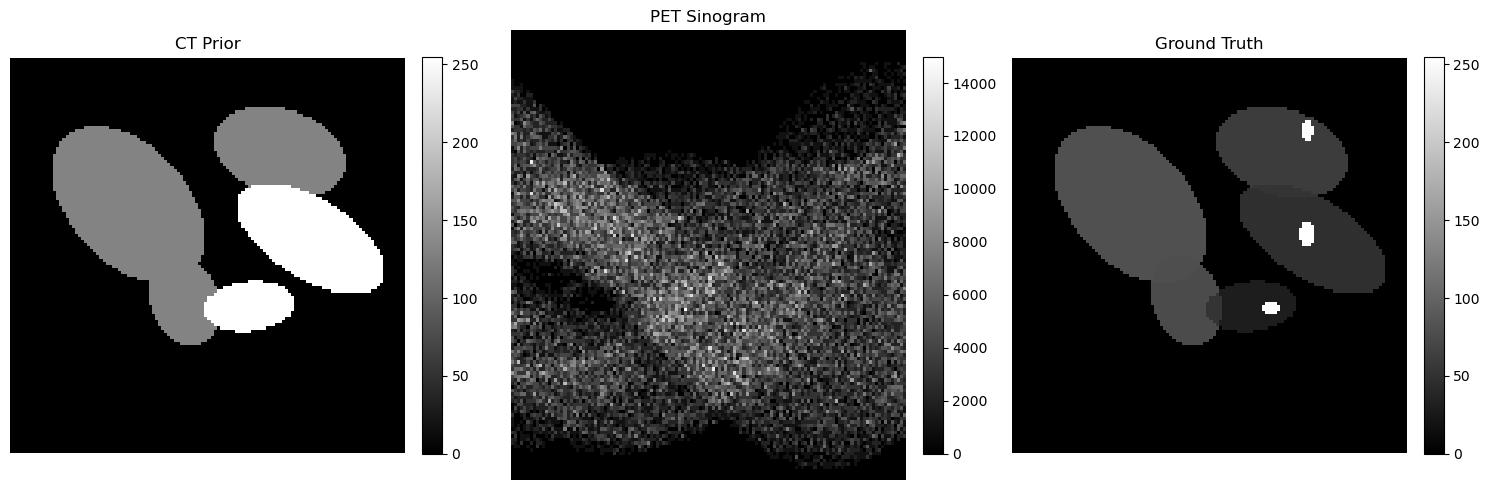

In [16]:
# Default values for reconstruction
angles = np.linspace(0., 180., max(ct_prior.shape), endpoint=False)

pet_sinogram = generate_sinogram_2d(ground_truth, angles)   # generate sinogram from pet image
pet_sinogram = add_poisson_noise(pet_sinogram, scale=0.001) # add lots of noise

# Plot CT image, PET Image and noisy sinogram
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im1 = axes[0].imshow(ct_prior, cmap='gray')
axes[0].set_title("CT Prior")
axes[0].axis("off")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(pet_sinogram, cmap='gray', aspect='auto')
axes[2].set_title("PET Sinogram")
axes[2].axis("off")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im3 = axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].axis("off")
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## KEM reconstruction
- using all filter option to find the best
- plot PSNR for each reconstruction

c:\ProgramData\Anaconda3\envs\recon\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Stopping early at iteration 57: PSNR and SSIM started decreasing.
Stopping early at iteration 21: PSNR and SSIM started decreasing.
Stopping early at iteration 23: PSNR and SSIM started decreasing.
Stopping early at iteration 66: PSNR and SSIM started decreasing.
Gaussian: Optimal PSNR Iteration = 5 with PSNR 21.83, Optimal SSIM Iteration = 100 with SSIM 0.6975
Bilateral: Optimal PSNR Iteration = 4 with PSNR 21.56, Optimal SSIM Iteration = 57 with SSIM 0.6637
Bayesian: Optimal PSNR Iteration = 4 with PSNR 21.74, Optimal SSIM Iteration = 21 with SSIM 0.6132
Anisotropic: Optimal PSNR Iteration = 5 with PSNR 21.93, Optimal SSIM Iteration = 23 with SSIM 0.6463
Gradient: Optimal PSNR Iteration = 1 with PSNR 18.82, Optimal SSIM Iteration = 66 with SSIM 0.5339


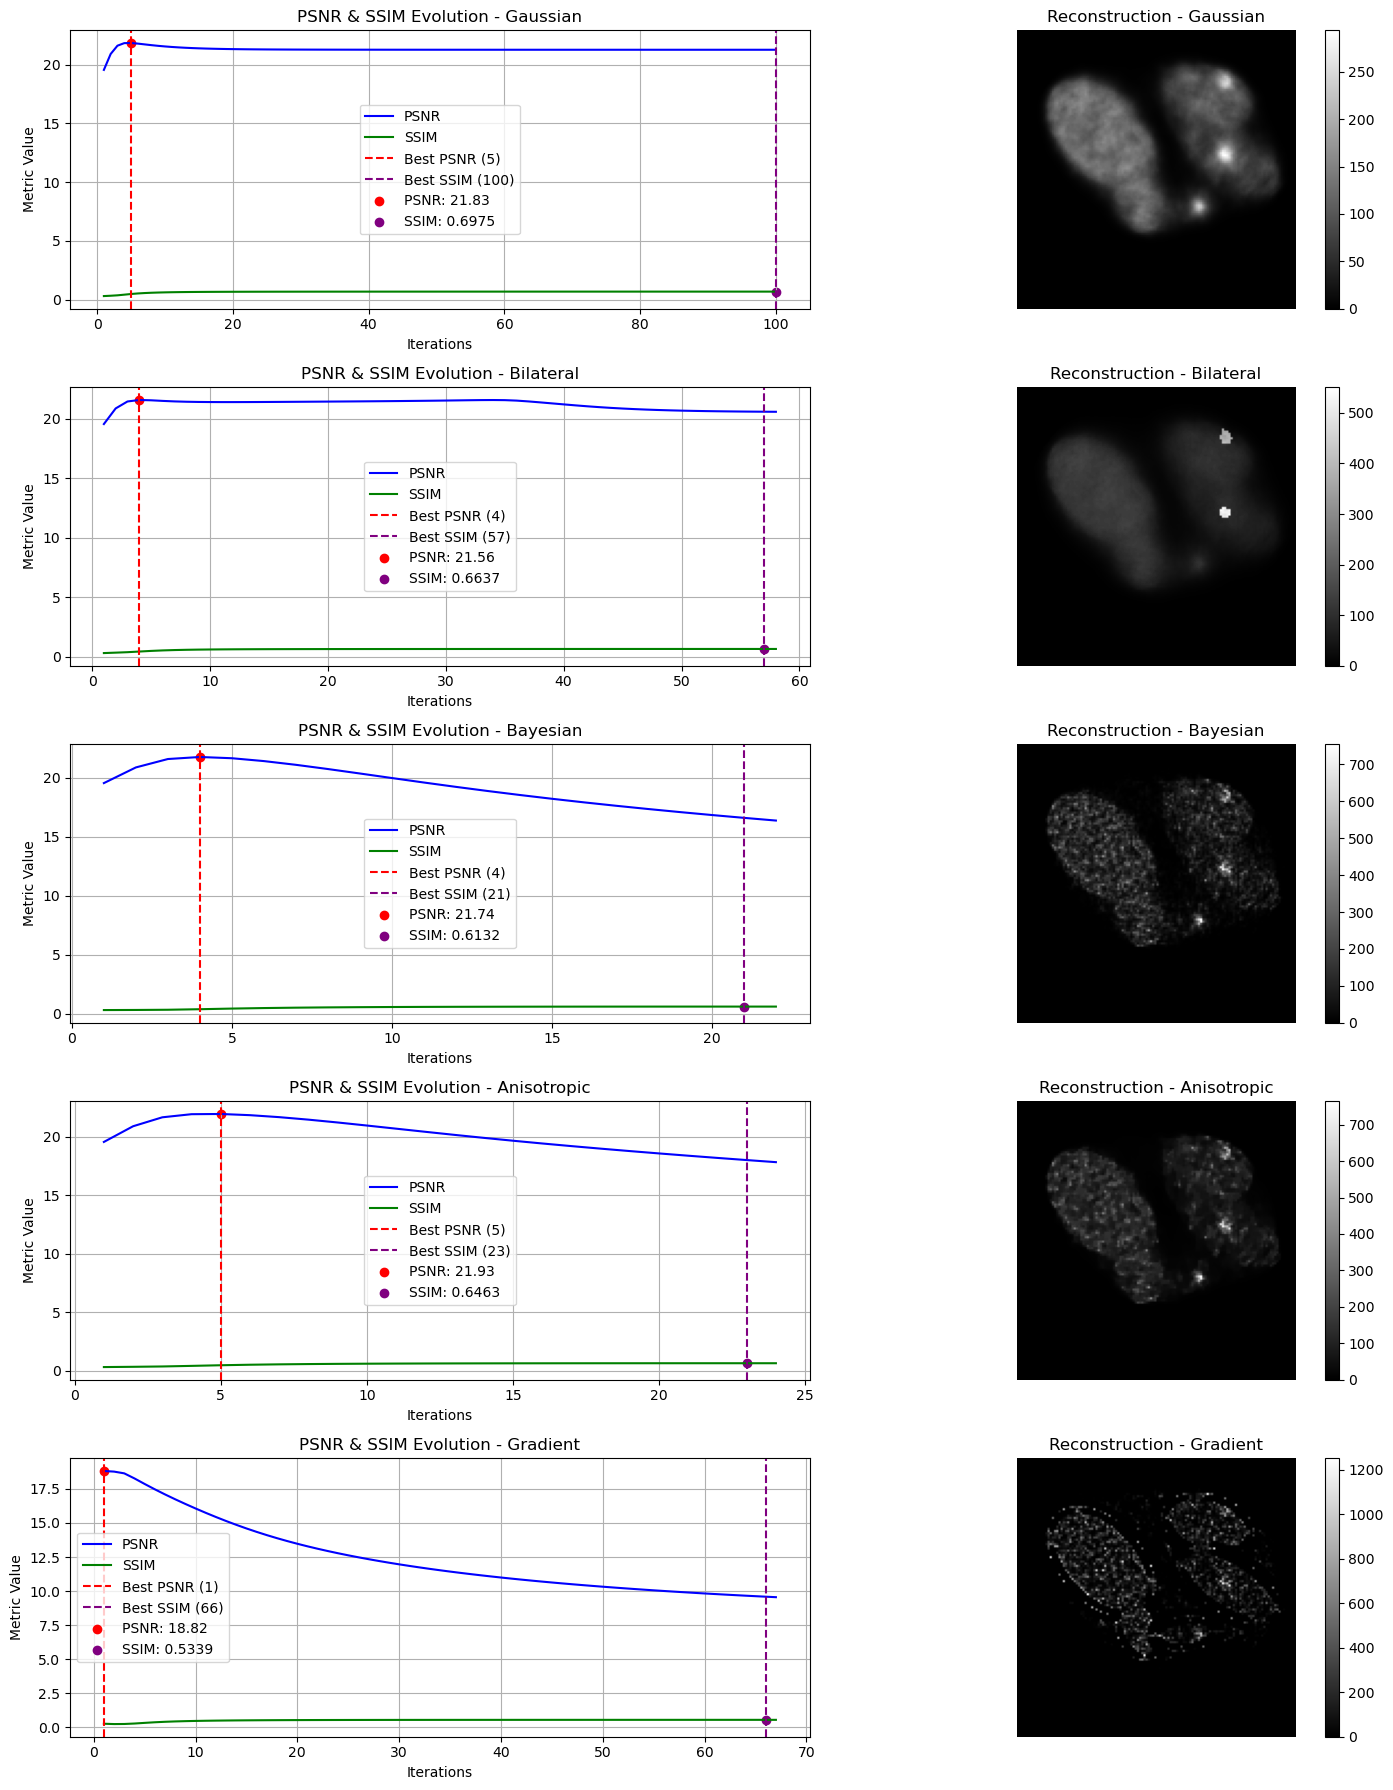

In [17]:
# recon, psnr_values, ssim_values, optimal_iter_psnr, optimal_iter_ssim

kem_gauss, psnr_kem_gauss, ssim_gauss, opti_psnr_gauss, opti_ssim_gauss = run_KEM_reconstruction(pet_sinogram, angles, ground_truth, ct_prior, filter_method="gaussian", num_iterations=100)
kem_bilateral, psnr_kem_bilateral, ssim_bilateral, opti_psnr_bilateral, opti_ssim_bilateral = run_KEM_reconstruction(pet_sinogram, angles, ground_truth, ct_prior, filter_method="bilateral", num_iterations=100)
kem_bayesian, psnr_kem_bayesian, ssim_bayesian, opti_psnr_bayesian, opti_ssim_bayesian = run_KEM_reconstruction(pet_sinogram, angles, ground_truth, ct_prior, filter_method="bayesian", num_iterations=100)
kem_anisotropic, psnr_kem_anisotropic, ssim_anisotropic, opti_psnr_anisotropic, opti_ssim_anisotropic = run_KEM_reconstruction(pet_sinogram, angles, ground_truth, ct_prior, filter_method="anisotropic", num_iterations=100)
kem_gradient, psnr_kem_gradient, ssim_gradient, opti_psnr_gradient, opti_ssim_gradient = run_KEM_reconstruction(pet_sinogram, angles, ground_truth, ct_prior, filter_method="gradient", num_iterations=100)


fig, axes = plt.subplots(5, 2, figsize=(14, 18), gridspec_kw={'width_ratios': [3, 3]})

# Define filter methods and corresponding data
filter_methods = ["Gaussian", "Bilateral", "Bayesian", "Anisotropic", "Gradient"]
psnr_values_list = [psnr_kem_gauss, psnr_kem_bilateral, psnr_kem_bayesian, psnr_kem_anisotropic, psnr_kem_gradient]
ssim_values_list = [ssim_gauss, ssim_bilateral, ssim_bayesian, ssim_anisotropic, ssim_gradient]
recon_images_list = [kem_gauss, kem_bilateral, kem_bayesian, kem_anisotropic, kem_gradient]
opt_psnr_list = [opti_psnr_gauss, opti_psnr_bilateral, opti_psnr_bayesian, opti_psnr_anisotropic, opti_psnr_gradient]
opt_ssim_list = [opti_ssim_gauss, opti_ssim_bilateral, opti_ssim_bayesian, opti_ssim_anisotropic, opti_ssim_gradient]

# Loop over filter methods
for i, (method, psnr_values, ssim_values, recon_image, opt_psnr, opt_ssim) in enumerate(zip(
    filter_methods, psnr_values_list, ssim_values_list, recon_images_list, opt_psnr_list, opt_ssim_list)):

    # Get PSNR and SSIM values at optimal iterations
    opt_psnr_value = psnr_values[opt_psnr - 1]  # Adjust index (1-based to 0-based)
    opt_ssim_value = ssim_values[opt_ssim - 1]

    # Plot PSNR and SSIM curves
    axes[i, 0].plot(range(1, len(psnr_values) + 1), psnr_values, linestyle='-', label="PSNR", color='b')
    axes[i, 0].plot(range(1, len(ssim_values) + 1), ssim_values, linestyle='-', label="SSIM", color='g')

    # Mark optimal iterations with vertical lines
    axes[i, 0].axvline(opt_psnr, color='r', linestyle="--", label=f"Best PSNR ({opt_psnr})")
    axes[i, 0].axvline(opt_ssim, color='purple', linestyle="--", label=f"Best SSIM ({opt_ssim})")

    # Mark optimal points on curves
    axes[i, 0].scatter(opt_psnr, opt_psnr_value, color='r', marker='o', label=f"PSNR: {opt_psnr_value:.2f}")
    axes[i, 0].scatter(opt_ssim, opt_ssim_value, color='purple', marker='o', label=f"SSIM: {opt_ssim_value:.4f}")

    axes[i, 0].set_xlabel("Iterations")
    axes[i, 0].set_ylabel("Metric Value")
    axes[i, 0].set_title(f"PSNR & SSIM Evolution - {method}")
    axes[i, 0].grid()
    axes[i, 0].legend()

    # Plot reconstructed image
    im = axes[i, 1].imshow(recon_image, cmap='gray')
    axes[i, 1].axis("off")
    axes[i, 1].set_title(f"Reconstruction - {method}")
    fig.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)

    # Print optimal values
    print(f"{method}: Optimal PSNR Iteration = {opt_psnr} with PSNR {opt_psnr_value:.2f}, "
          f"Optimal SSIM Iteration = {opt_ssim} with SSIM {opt_ssim_value:.4f}")

plt.tight_layout()
plt.show()


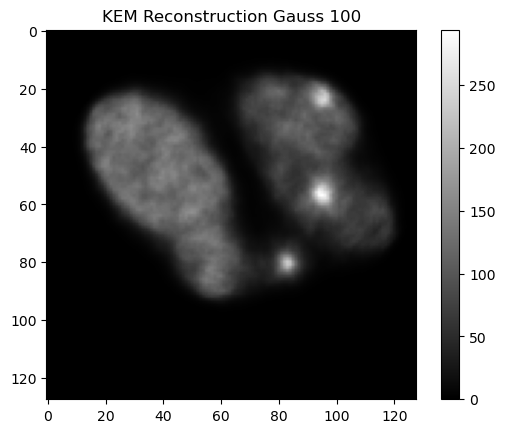

Stopping early at iteration 57: PSNR and SSIM started decreasing.


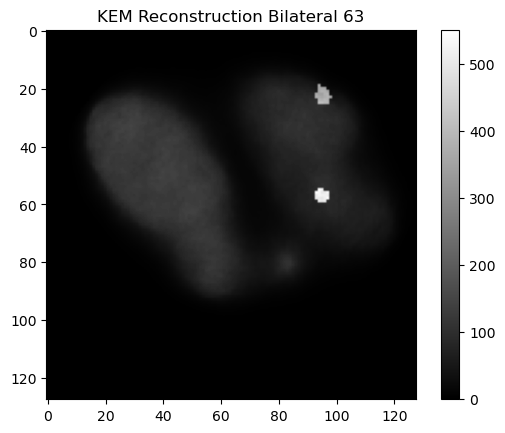

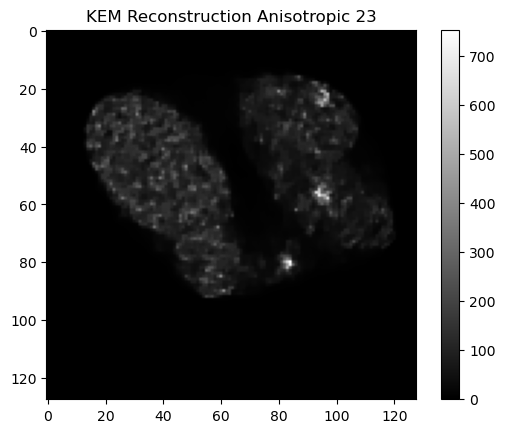

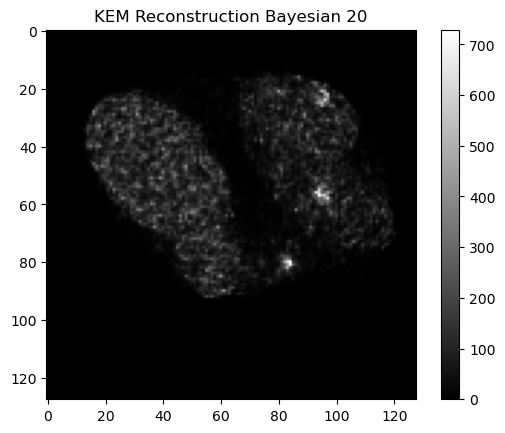

In [18]:
# print the opti combis
only_kem_result, _ , _ , _ , _ = run_KEM_reconstruction(pet_sinogram, angles, ground_truth, ct_prior, filter_method="gaussian", num_iterations=100)

plt.imshow(only_kem_result, cmap='gray')
plt.title('KEM Reconstruction Gauss 100')
plt.colorbar()
plt.show()

only_kem_result, _ , _ , _ , _ = run_KEM_reconstruction(pet_sinogram, angles, ground_truth, ct_prior, filter_method="bilateral", num_iterations=63)

plt.imshow(only_kem_result, cmap='gray')
plt.title('KEM Reconstruction Bilateral 63')
plt.colorbar()
plt.show()

only_kem_result, _ , _ , _ , _ = run_KEM_reconstruction(pet_sinogram, angles, ground_truth, ct_prior, filter_method="anisotropic", num_iterations=23)

plt.imshow(only_kem_result, cmap='gray')
plt.title('KEM Reconstruction Anisotropic 23')
plt.colorbar()
plt.show()

only_kem_result, _ , _ , _ , _ = run_KEM_reconstruction(pet_sinogram, angles, ground_truth, ct_prior, filter_method="bayesian", num_iterations=20)

plt.imshow(only_kem_result, cmap='gray')
plt.title('KEM Reconstruction Bayesian 20')
plt.colorbar()
plt.show()

## MLEM Reconstruction

In [19]:
def plot_psnr_ssim_for_mlem(psnr_values, ssim_values, opti_psnr_iter, opti_ssim_iter, reconstructed_image):
    # plot(range(1, len(ssim_values) + 1), ssim_values, linestyle='-', label="SSIM", color='g')
    #iterations = range(1, len(psnr_values) + 1)

    # Get PSNR and SSIM values at optimal iterations
    opt_psnr_value = psnr_values[opti_psnr_iter - 1]  # Adjust index (1-based to 0-based)
    opt_ssim_value = ssim_values[opti_ssim_iter - 1]

    # Create the plot with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Plot PSNR and SSIM curves
    axes[0].plot(range(1, len(psnr_values) + 1), psnr_values, linestyle='-', label="PSNR", color='b')
    axes[0].plot(range(1, len(ssim_values) + 1), ssim_values, linestyle='-', label="SSIM", color='g')

    # Mark optimal iterations with vertical lines
    axes[0].axvline(opti_psnr_iter, color='r', linestyle="--", label=f"Best PSNR ({opti_psnr_iter})")
    axes[0].axvline(opti_ssim_iter, color='purple', linestyle="--", label=f"Best SSIM ({opti_ssim_iter})")

    # Mark optimal points on curves
    axes[0].scatter(opti_psnr_iter, opt_psnr_value, color='r', marker='o', label=f"PSNR: {opt_psnr_value:.2f}")
    axes[0].scatter(opti_ssim_iter, opt_ssim_value, color='purple', marker='o', label=f"SSIM: {opt_ssim_value:.4f}")

    # Add labels, title, grid, and legend
    axes[0].set_xlabel("Iterations")
    axes[0].set_ylabel("Metric Value")
    axes[0].set_title("PSNR & SSIM Evolution for MLEM")
    axes[0].grid()
    axes[0].legend()

    # Plot the reconstructed image
    im = axes[1].imshow(reconstructed_image, cmap='gray')
    axes[1].axis("off")
    axes[1].set_title("MLEM")
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


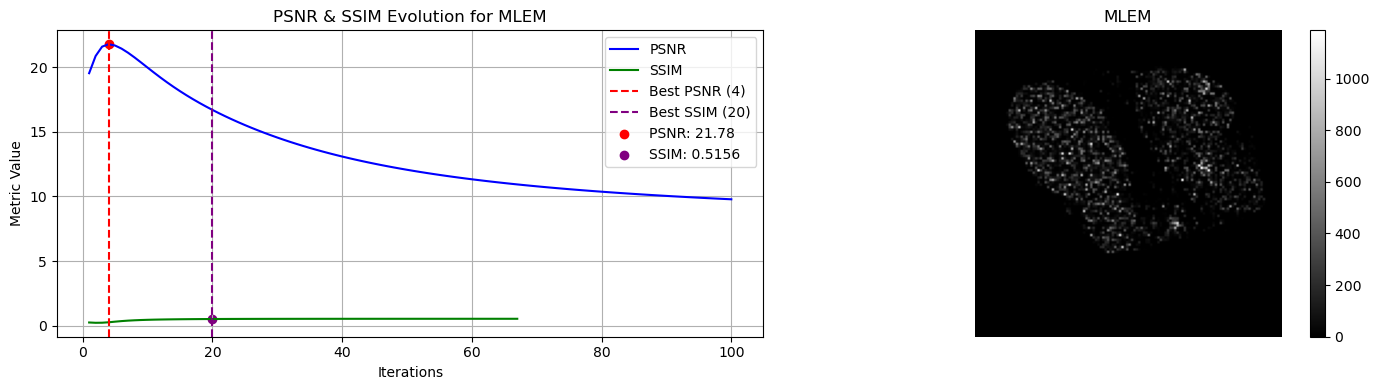

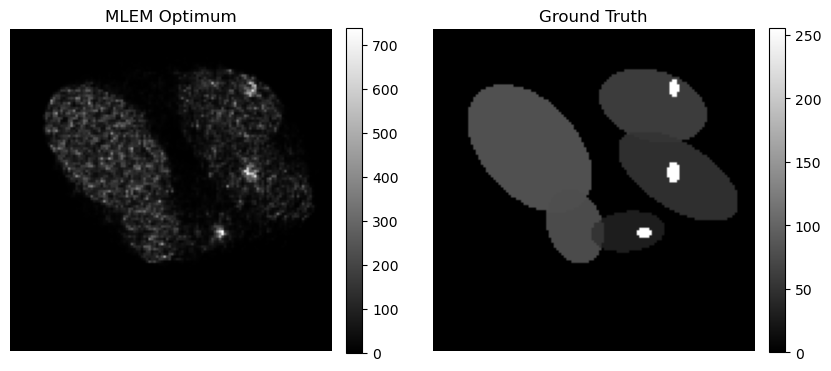

In [20]:
mlem_reconstructed, psnr_values, ssim_mlem, opti_psnr_mlem, opti_ssim_mlem = MLEM_reconstruction(pet_sinogram, angles, ground_truth, num_iterations=100)

plot_psnr_ssim_for_mlem(psnr_values, ssim_values, opti_psnr_mlem, opti_ssim_mlem, mlem_reconstructed)

mlem_reconstructed, _ , _ , _ , _ = MLEM_reconstruction(pet_sinogram, angles, ground_truth, num_iterations=20)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  
im1 = axes[0].imshow(mlem_reconstructed, cmap='gray') 
axes[0].set_title("MLEM Optimum")  
axes[0].axis('off')  
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04) 
 
im2 = axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
plt.show()

## Deep Image Prior 
**Combination of KEM and DIP**
- design U-Net using skip
- include 2-channel input (KEM recon + CT prior)
- calculate loss function
- weight the influence of KEM and DIP 

Notes for Loss:

MSE: Measures how close the refined image is to the original KEM reconstruction

SSIM: Compares the refined image to the CT prior, focusing on contrast, structure, and brightness, Ensures retains important anatomical structures

TV (Total Variation): Reduces small, unnecessary noise while keeping edges intact, removes noise without destroying important details

Gradient Diff Loss: Makes sure that the edges in the refined image match those in the CT prior, maintain sharp details like bones and organ boundaries from the CT image

 $$Total Loss = MSE Loss or L1 Loss + 0.3×SSIM Loss + 0.05×TV Loss + 0.5×Edge Loss ???? $$

- MSE keeps the image faithful to KEM
- SSIM ensures similarity to CT
- TV smooths out noise
- Edge Loss keeps sharp details

In [21]:

def total_variation_loss(image): # TV loss to remove noise while keeping structure
    return torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
           torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))

def gradient_difference_loss(output, ct_prior): # Encourages sharp edges from CT to be preserved
    grad_output_x = output[:, :, :, :-1] - output[:, :, :, 1:]
    grad_output_y = output[:, :, :-1, :] - output[:, :, 1:, :]
    
    grad_ct_x = ct_prior[:, :, :, :-1] - ct_prior[:, :, :, 1:]
    grad_ct_y = ct_prior[:, :, :-1, :] - ct_prior[:, :, 1:, :]
    
    return torch.mean(torch.abs(grad_output_x - grad_ct_x)) + torch.mean(torch.abs(grad_output_y - grad_ct_y))



def run_dip_kem_refinement(kem_image, ct_image, loss="mse", alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert to tensors
    kem_recon = torch.tensor(kem_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,H,W)
    ct_prior = torch.tensor(ct_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,H,W)

    # Normalize images
    kem_recon = (kem_recon - kem_recon.min()) / (kem_recon.max() - kem_recon.min())
    ct_prior = (ct_prior - ct_prior.min()) / (ct_prior.max() - ct_prior.min())

    # Resize CT prior if needed
    if ct_prior.shape != kem_recon.shape:
        ct_prior = F.interpolate(ct_prior, size=kem_recon.shape[2:], mode="bilinear", align_corners=False)

    # Define DIP Model (Use a skip network like U-Net)
    net = skip(2, 1,  # Two channels: KEM + CT Prior
        num_channels_down=[16, 32, 64, 128, 128],
        num_channels_up=[16, 32, 64, 128, 128],
        num_channels_skip=[4, 4, 4, 4, 4],
        upsample_mode='bilinear',
        need_sigmoid=True, 
        need_bias=True,
        pad='reflection', 
        act_fun='LeakyReLU').to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    mse_loss = torch.nn.MSELoss()
    l1_loss = torch.nn.L1Loss()

    ssim_loss_fn = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    # DIP Input (KEM + CT prior)
    dip_input = torch.cat((kem_recon, ct_prior), dim=1)
    
    # Training Loop
    for i in range(num_iterations):
        optimizer.zero_grad()
    
        dip_output = net(dip_input)
    
        # Fidelity Loss (KEM)
        if loss == "mse":
            fidelity_loss = mse_loss(dip_output, kem_recon)
        if loss == "l1":
            fidelity_loss = l1_loss(dip_output, kem_recon)

        # Structural Similarity Loss (CT Prior)
        ssim_loss = 1 - ssim_loss_fn(dip_output, ct_prior)

        # Regularization Losses
        tv_loss = total_variation_loss(dip_output)
        edge_loss = gradient_difference_loss(dip_output, ct_prior)

        # Adjust weights
        total_loss = fidelity_loss + alpha * ssim_loss + beta * tv_loss + gamma * edge_loss  

        total_loss.backward()
        optimizer.step()

    # Final refined image
    final_image = a * dip_output.squeeze().detach().cpu().numpy() + \
              b * kem_recon.squeeze().detach().cpu().numpy()

    return final_image


**Testing different Loss Functions for MSE as Fidelity Loss**

In [22]:
# changing learning rate
refined_image_mse_1 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.0001)
refined_image_mse_2 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001) 
refined_image_mse_3 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.01)

# changing a and b
refined_image_mse_4 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.05, gamma=0.5, a=0.4, b=0.6, num_iterations=1000, lr=0.001)
refined_image_mse_5 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.05, gamma=0.5, a=0.5, b=0.5, num_iterations=1000, lr=0.001)
refined_image_mse_6 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.05, gamma=0.5, a=0.6, b=0.4, num_iterations=1000, lr=0.001)
refined_image_mse_7 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.05, gamma=0.5, a=0.7, b=0.3, num_iterations=1000, lr=0.001)

# changing alpa
refined_image_mse_8  = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.4, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_mse_9  = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.5, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_mse_10 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.6, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_mse_11 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.7, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)

# changing beta
refined_image_mse_12 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.02, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_mse_13 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.03, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_mse_14 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.07, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_mse_15 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.09, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)

# changing gamma
refined_image_mse_16 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.05, gamma=0.2, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_mse_17 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="mse", alpha=0.3, beta=0.05, gamma=0.7, a=0.3, b=0.7, num_iterations=1000, lr=0.001)

**Testing different Loss Functions for L1 as Fidelity Loss**

In [23]:
# changing learning rate
refined_image_l1_1 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.0001)
refined_image_l1_2 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001) 
refined_image_l1_3 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.01)

# changing a and b
refined_image_l1_4 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.05, gamma=0.5, a=0.4, b=0.6, num_iterations=1000, lr=0.001)
refined_image_l1_5 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.05, gamma=0.5, a=0.5, b=0.5, num_iterations=1000, lr=0.001)
refined_image_l1_6 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.05, gamma=0.5, a=0.6, b=0.4, num_iterations=1000, lr=0.001)
refined_image_l1_7 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.05, gamma=0.5, a=0.7, b=0.3, num_iterations=1000, lr=0.001)

# changing alpa
refined_image_l1_8  = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.4, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_l1_9  = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.5, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_l1_10 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.6, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_l1_11 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.7, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)

# changing beta
refined_image_l1_12 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.02, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_l1_13 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.03, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_l1_14 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.07, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_l1_15 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.09, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)

# changing gamma
refined_image_l1_16 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.05, gamma=0.2, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
refined_image_l1_17 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.05, gamma=0.7, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
#refined_image_l1_18 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)
#refined_image_l1_19 = run_dip_kem_refinement(only_kem_result, ct_prior, loss="l1", alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, num_iterations=1000, lr=0.001)

## Evaluation of Different Parameter Combination

With MSE: 



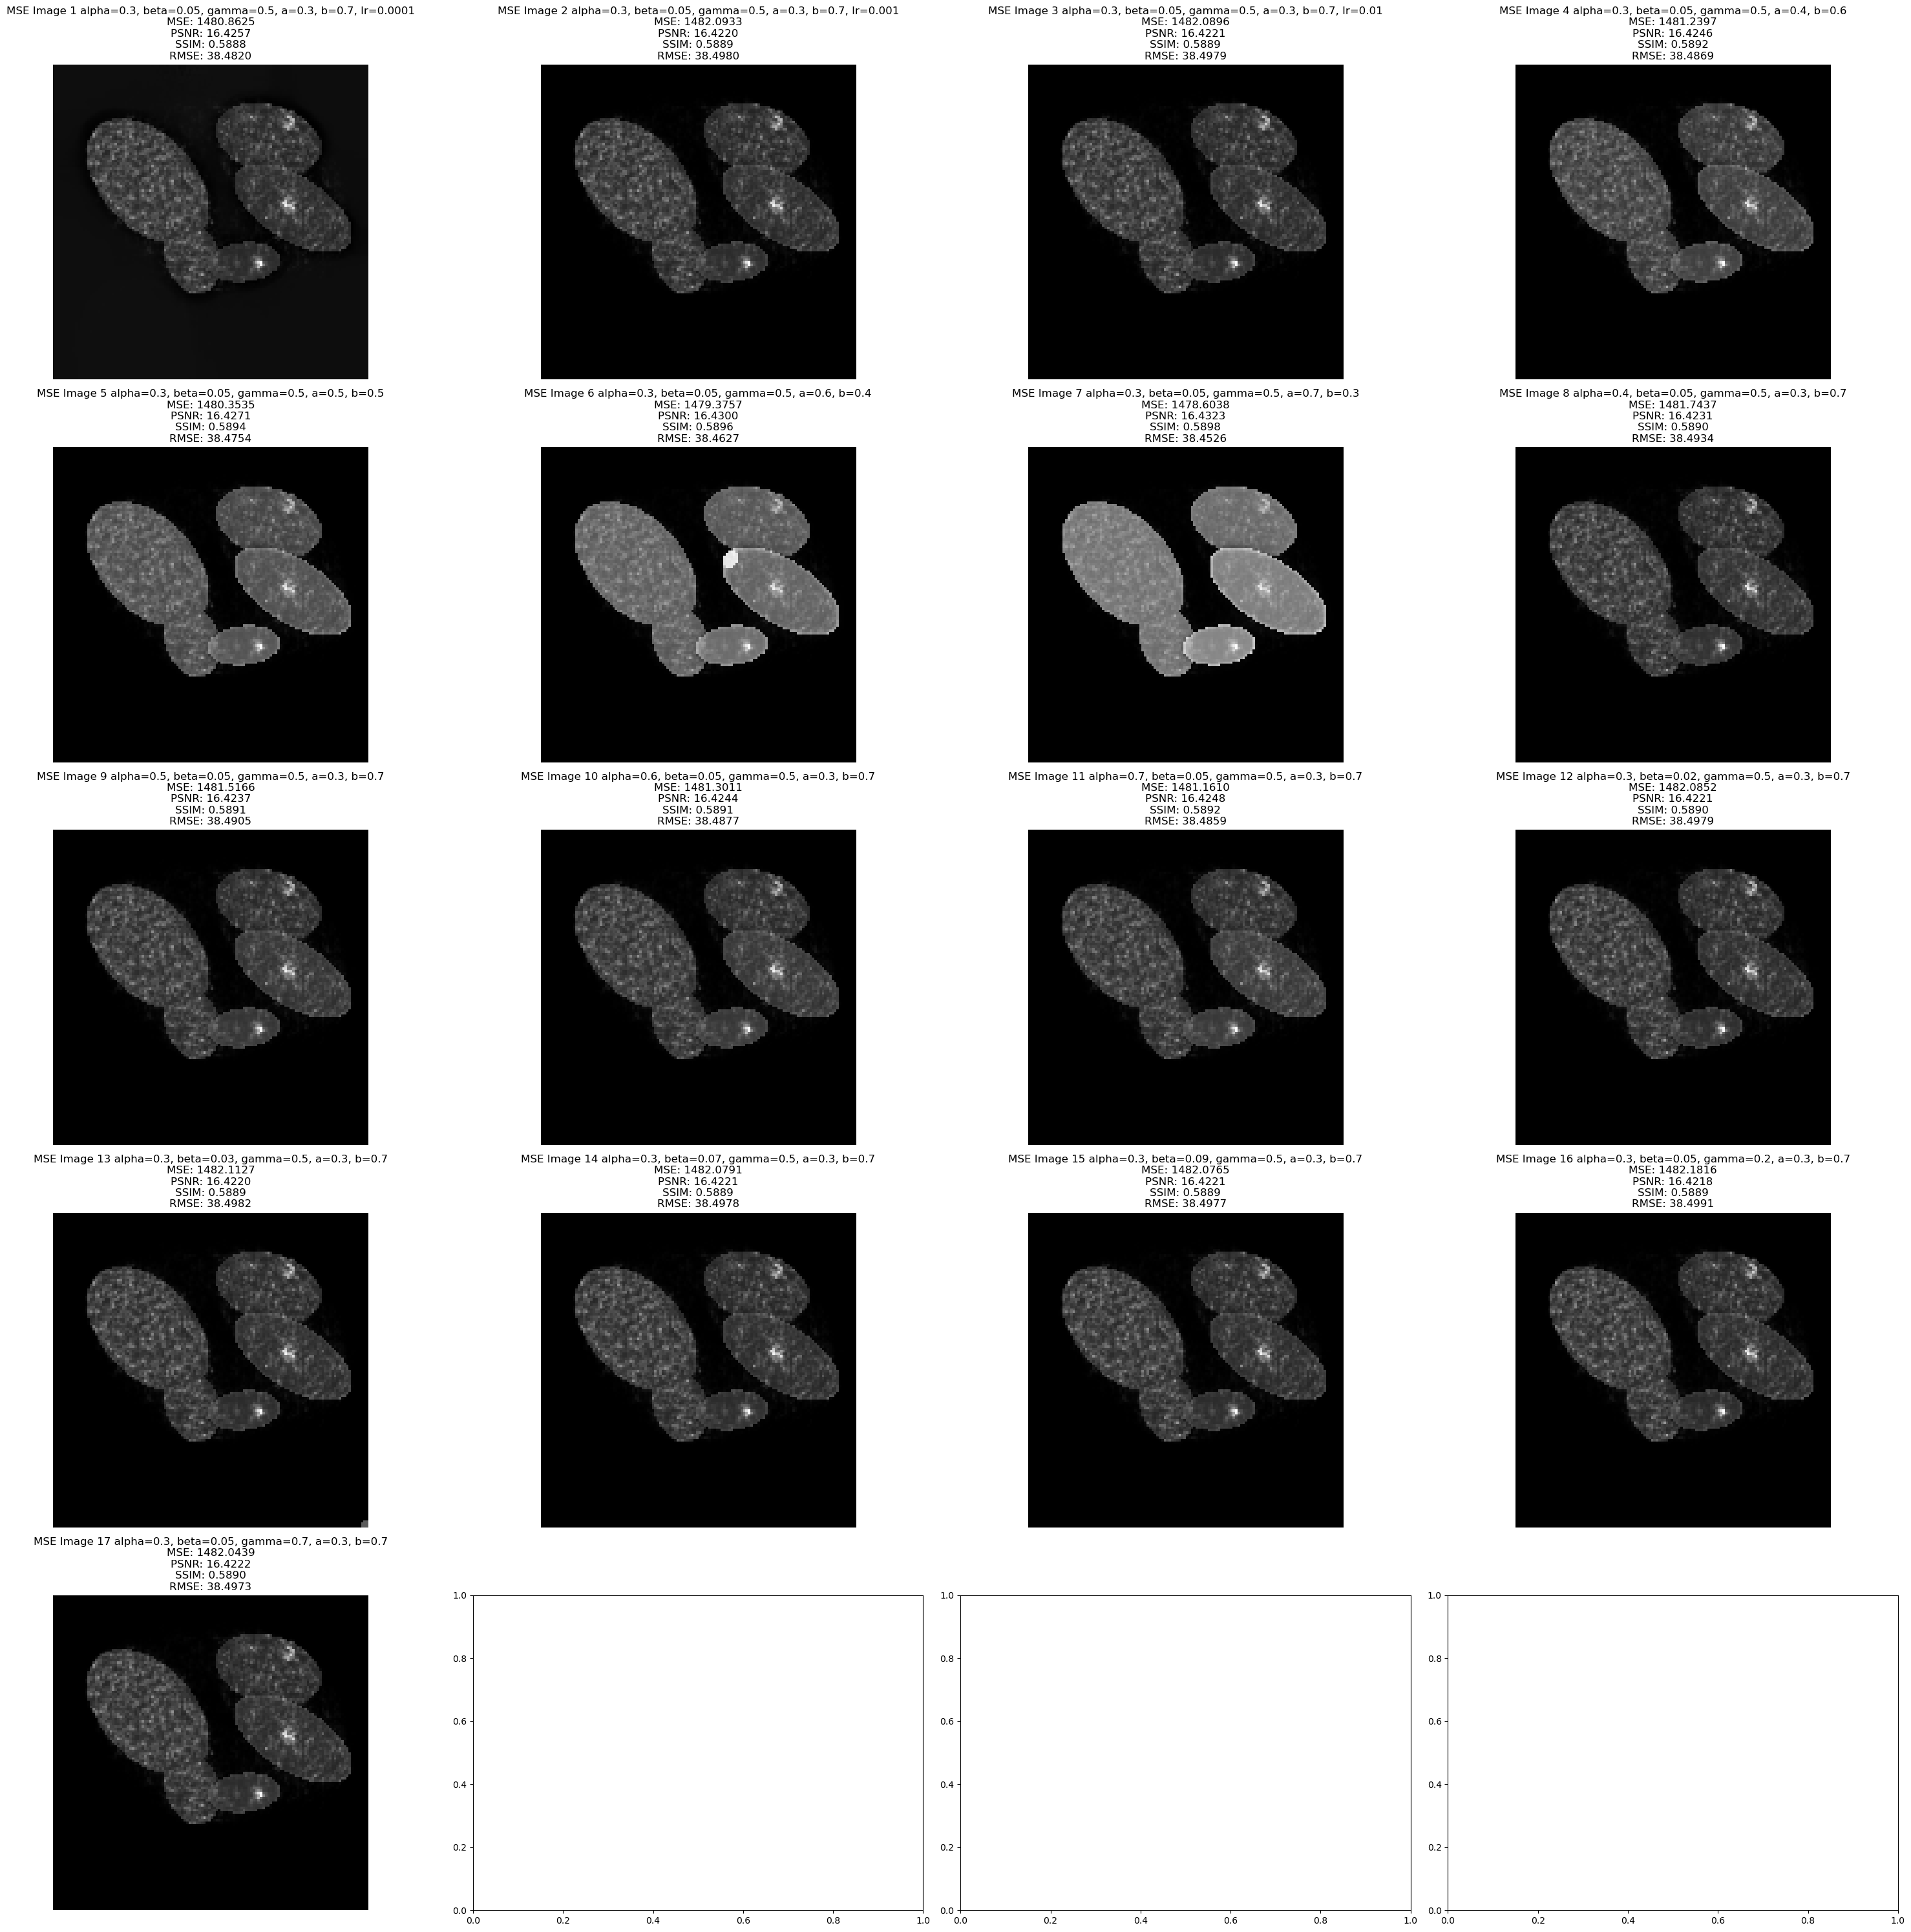

In [24]:
# List of MSE refined images
refined_images = [
    refined_image_mse_1, refined_image_mse_2, refined_image_mse_3, refined_image_mse_4, refined_image_mse_5,
    refined_image_mse_6, refined_image_mse_7, refined_image_mse_8, refined_image_mse_9, refined_image_mse_10,
    refined_image_mse_11, refined_image_mse_12, refined_image_mse_13, refined_image_mse_14, refined_image_mse_15,
    refined_image_mse_16, refined_image_mse_17
]

titles = [
    'MSE Image 1 alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, lr=0.0001',
    'MSE Image 2 alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, lr=0.001',
    'MSE Image 3 alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, lr=0.01',
    'MSE Image 4 alpha=0.3, beta=0.05, gamma=0.5, a=0.4, b=0.6',
    'MSE Image 5 alpha=0.3, beta=0.05, gamma=0.5, a=0.5, b=0.5',
    'MSE Image 6 alpha=0.3, beta=0.05, gamma=0.5, a=0.6, b=0.4',
    'MSE Image 7 alpha=0.3, beta=0.05, gamma=0.5, a=0.7, b=0.3',
    'MSE Image 8 alpha=0.4, beta=0.05, gamma=0.5, a=0.3, b=0.7',
    'MSE Image 9 alpha=0.5, beta=0.05, gamma=0.5, a=0.3, b=0.7',
    'MSE Image 10 alpha=0.6, beta=0.05, gamma=0.5, a=0.3, b=0.7',
    'MSE Image 11 alpha=0.7, beta=0.05, gamma=0.5, a=0.3, b=0.7',
    'MSE Image 12 alpha=0.3, beta=0.02, gamma=0.5, a=0.3, b=0.7',
    'MSE Image 13 alpha=0.3, beta=0.03, gamma=0.5, a=0.3, b=0.7',
    'MSE Image 14 alpha=0.3, beta=0.07, gamma=0.5, a=0.3, b=0.7',
    'MSE Image 15 alpha=0.3, beta=0.09, gamma=0.5, a=0.3, b=0.7',
    'MSE Image 16 alpha=0.3, beta=0.05, gamma=0.2, a=0.3, b=0.7',
    'MSE Image 17 alpha=0.3, beta=0.05, gamma=0.7, a=0.3, b=0.7'
]

print("With MSE: \n")

fig, axes = plt.subplots(5, 4, figsize=(30, 30))
axes = axes.ravel()

for i, (img, title) in enumerate(zip(refined_images, titles)):
    mse, psnr, ssim_val, rmse = evaluate_reconstruction(ground_truth, img)

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'{title}\nMSE: {mse:.4f}\nPSNR: {psnr:.4f}\nSSIM: {ssim_val:.4f}\nRMSE: {rmse:.4f}')
    axes[i].axis('off')
    

plt.tight_layout()
plt.show()

With L1: 



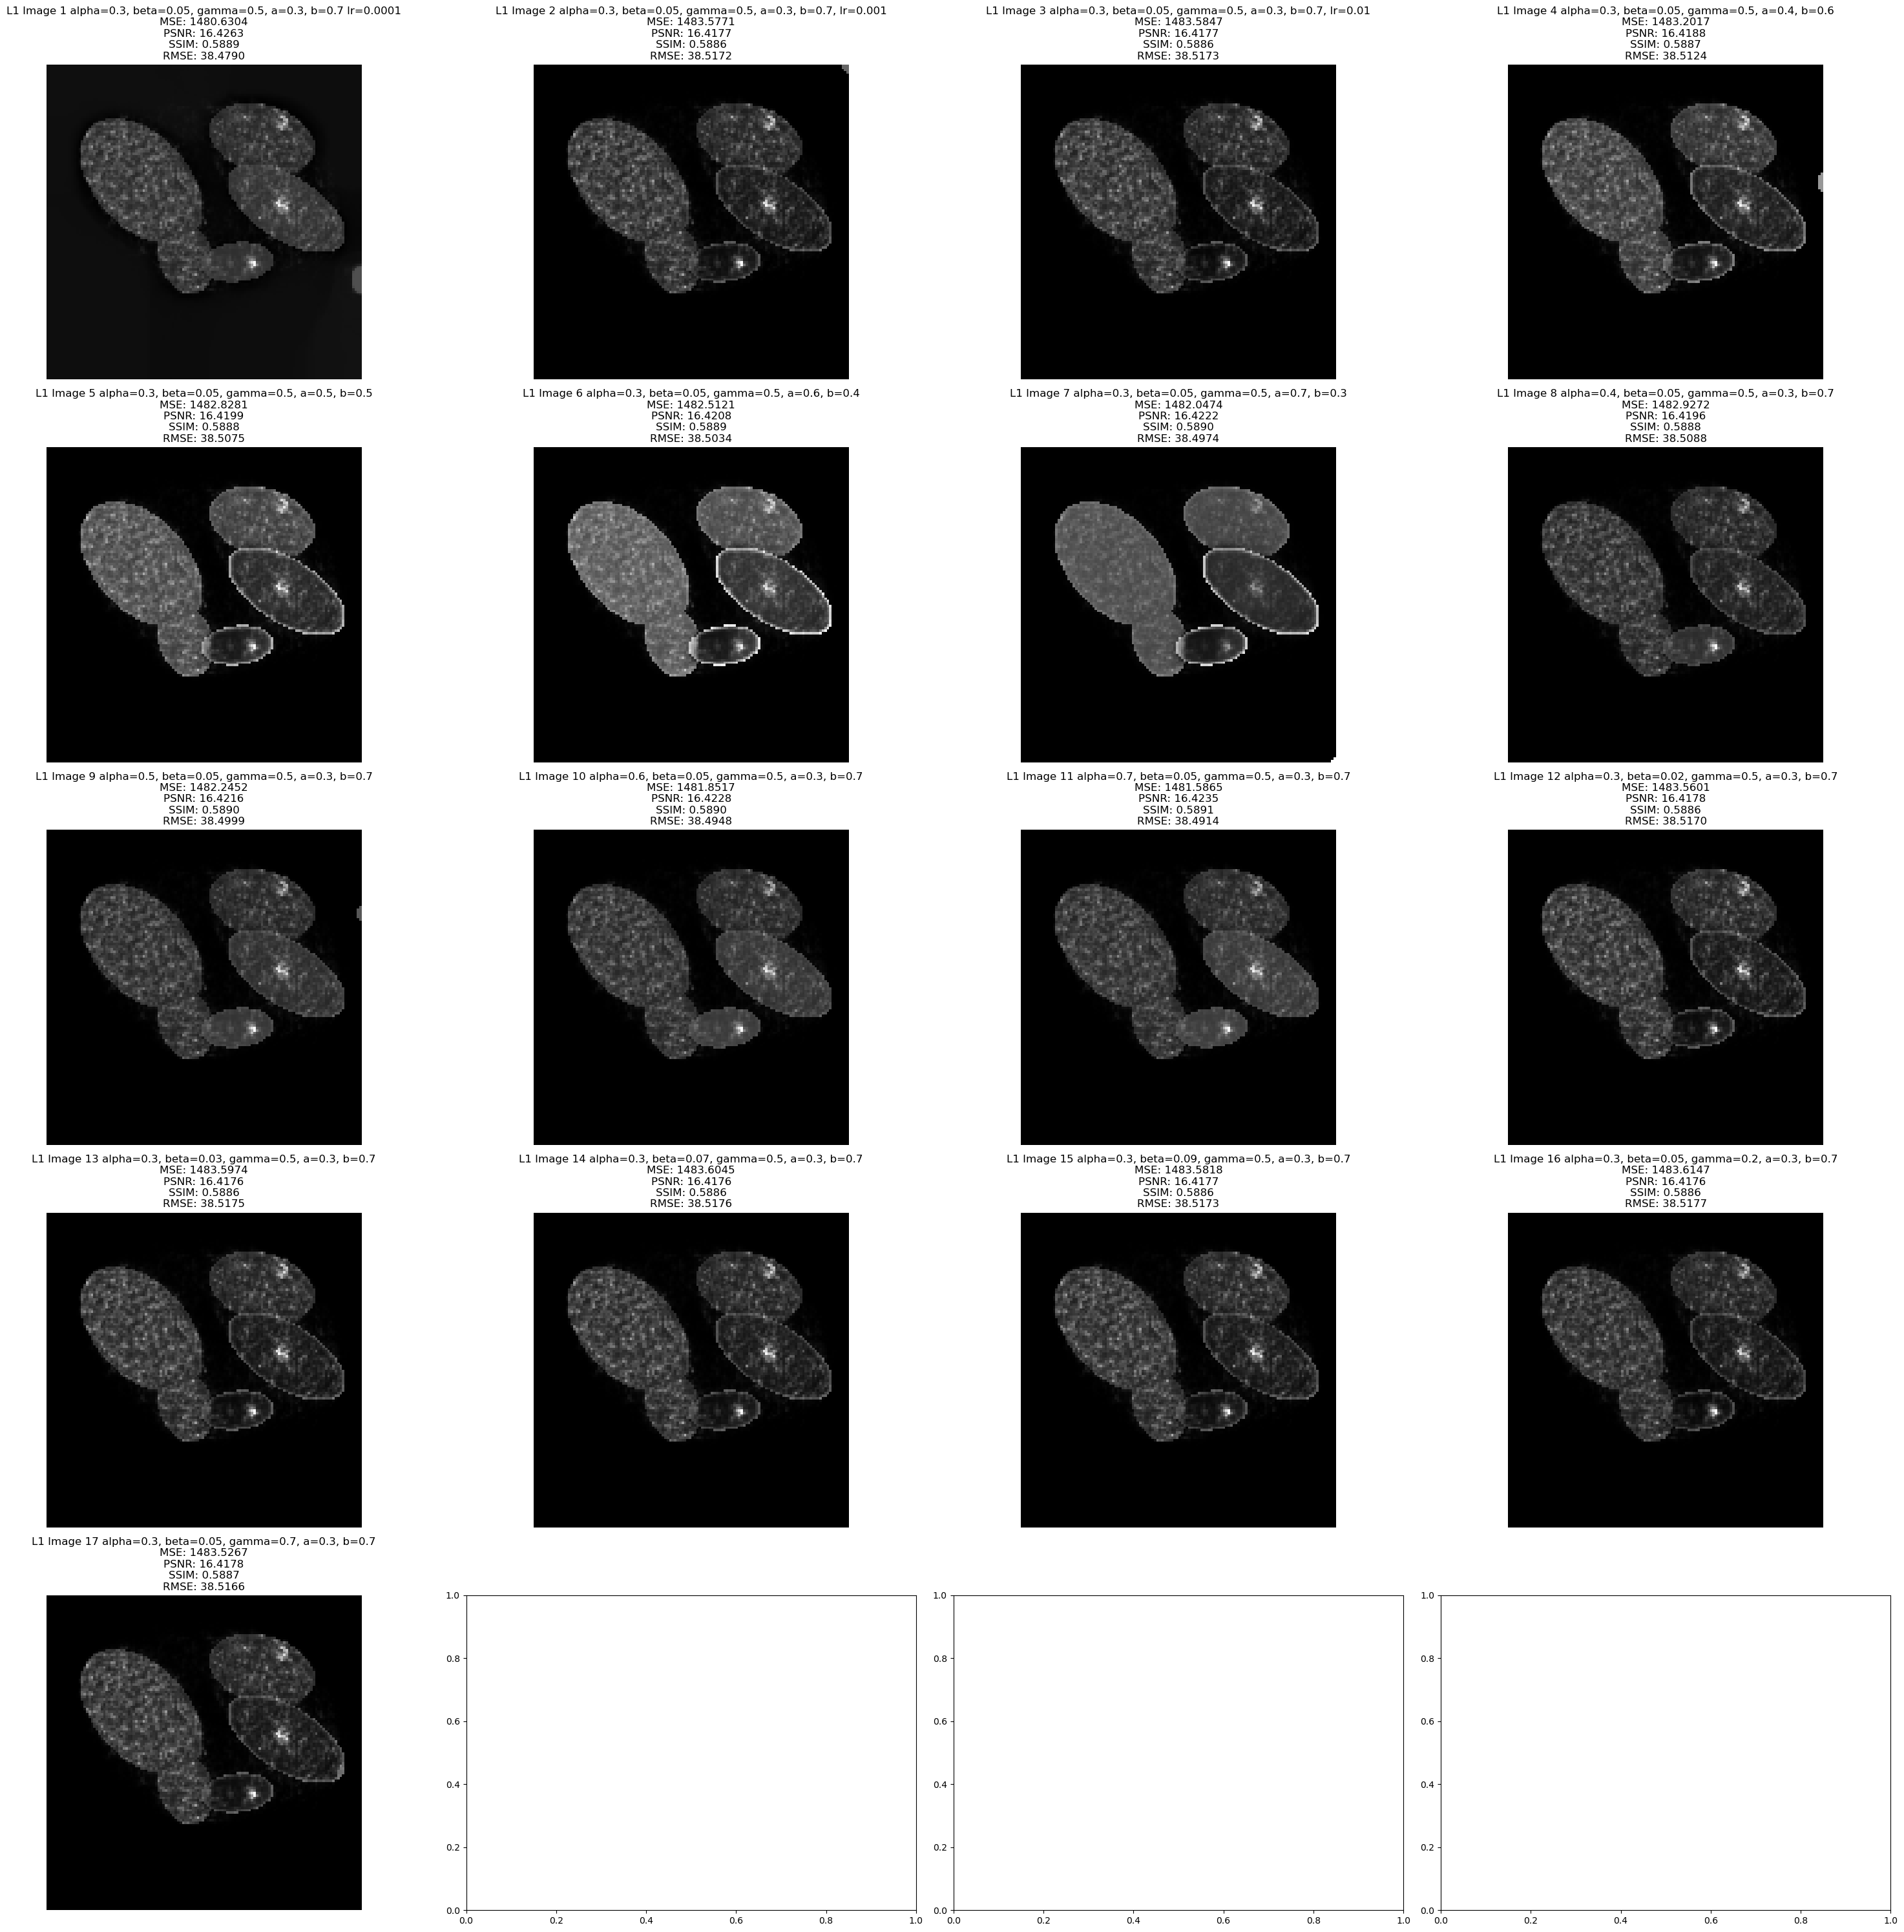

In [25]:
# List of L1 refined images
refined_images_l1 = [
    refined_image_l1_1, refined_image_l1_2, refined_image_l1_3, refined_image_l1_4, refined_image_l1_5,
    refined_image_l1_6, refined_image_l1_7, refined_image_l1_8, refined_image_l1_9, refined_image_l1_10,
    refined_image_l1_11, refined_image_l1_12, refined_image_l1_13, refined_image_l1_14, refined_image_l1_15,
    refined_image_l1_16, refined_image_l1_17
]

titles_l1 = [
    'L1 Image 1 alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7 lr=0.0001', 
    'L1 Image 2 alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, lr=0.001',
    'L1 Image 3 alpha=0.3, beta=0.05, gamma=0.5, a=0.3, b=0.7, lr=0.01', 
    'L1 Image 4 alpha=0.3, beta=0.05, gamma=0.5, a=0.4, b=0.6',
    'L1 Image 5 alpha=0.3, beta=0.05, gamma=0.5, a=0.5, b=0.5', 
    'L1 Image 6 alpha=0.3, beta=0.05, gamma=0.5, a=0.6, b=0.4',
    'L1 Image 7 alpha=0.3, beta=0.05, gamma=0.5, a=0.7, b=0.3', 
    'L1 Image 8 alpha=0.4, beta=0.05, gamma=0.5, a=0.3, b=0.7',
    'L1 Image 9 alpha=0.5, beta=0.05, gamma=0.5, a=0.3, b=0.7', 
    'L1 Image 10 alpha=0.6, beta=0.05, gamma=0.5, a=0.3, b=0.7',
    'L1 Image 11 alpha=0.7, beta=0.05, gamma=0.5, a=0.3, b=0.7', 
    'L1 Image 12 alpha=0.3, beta=0.02, gamma=0.5, a=0.3, b=0.7',
    'L1 Image 13 alpha=0.3, beta=0.03, gamma=0.5, a=0.3, b=0.7', 
    'L1 Image 14 alpha=0.3, beta=0.07, gamma=0.5, a=0.3, b=0.7',
    'L1 Image 15 alpha=0.3, beta=0.09, gamma=0.5, a=0.3, b=0.7', 
    'L1 Image 16 alpha=0.3, beta=0.05, gamma=0.2, a=0.3, b=0.7',
    'L1 Image 17 alpha=0.3, beta=0.05, gamma=0.7, a=0.3, b=0.7'
]

print("With L1: \n")

fig, axes = plt.subplots(5, 4, figsize=(30, 30))
axes = axes.ravel()  # Flatten the axes for easy iteration

for i, (img, title) in enumerate(zip(refined_images_l1, titles_l1)):
    mse, psnr, ssim_val, rmse = evaluate_reconstruction(ground_truth, img)

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'{title}\nMSE: {mse:.4f}\nPSNR: {psnr:.4f}\nSSIM: {ssim_val:.4f}\nRMSE: {rmse:.4f}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

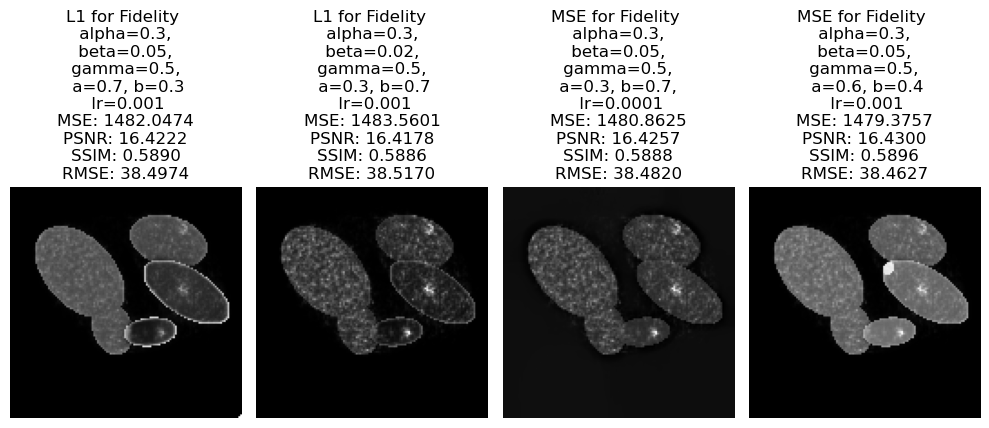

In [26]:
# plots for presentation
refined_images = [
    refined_image_l1_7,   
    refined_image_l1_12,  
    refined_image_mse_1, 
    refined_image_mse_6, 
]

titles = [ 
    'L1 for Fidelity \n alpha=0.3, \n beta=0.05, \n gamma=0.5, \n a=0.7, b=0.3\n lr=0.001',  
    'L1 for Fidelity \n alpha=0.3, \n beta=0.02, \n gamma=0.5, \n a=0.3, b=0.7\n lr=0.001',
    'MSE for Fidelity \n alpha=0.3, \n beta=0.05, \n gamma=0.5, \n a=0.3, b=0.7, \n lr=0.0001',
    'MSE for Fidelity \n alpha=0.3, \n beta=0.05, \n gamma=0.5, \n a=0.6, b=0.4\n lr=0.001',
]


fig, axes = plt.subplots(1, 4, figsize=(10, 10))
axes = axes.ravel()  # Flatten the axes for easy iteration

for i, (img, title) in enumerate(zip(refined_images, titles)):
    mse, psnr, ssim_val, rmse = evaluate_reconstruction(ground_truth, img)

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'{title}\nMSE: {mse:.4f}\nPSNR: {psnr:.4f}\nSSIM: {ssim_val:.4f}\nRMSE: {rmse:.4f}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


**Check for the best combination**
- Lowest MSE (Mean Squared Error) → Lower is better.
- Highest PSNR (Peak Signal-to-Noise Ratio) → Higher is better.
- Highest SSIM (Structural Similarity Index) → Higher is better.
- Lowest RMSE (Root Mean Squared Error) → Lower is better.

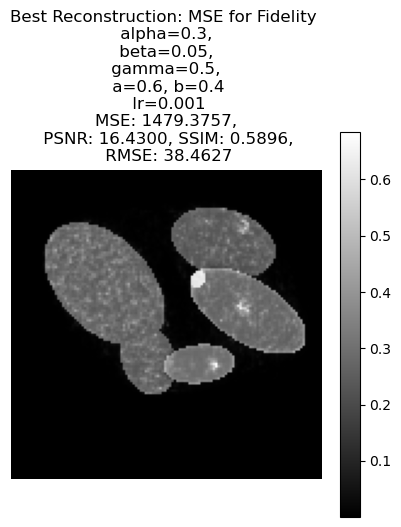

In [27]:
def find_best_reconstruction(refined_images, titles, ground_truth):
    best_score = -np.inf  # Initialize with a very low score
    best_image = None
    best_title = ""
    best_metrics = {}
    
    for img, title in zip(refined_images, titles):
        mse, psnr, ssim_val, rmse = evaluate_reconstruction(ground_truth, img) # call the evaluation function for each recon
        
        # Define a scoring metric: prioritize low MSE & RMSE, high PSNR & SSIM
        score = psnr + ssim_val - (mse + rmse)  # My own scoring function that can be changed depending which metrics is more important
        
        if score > best_score:
            best_score = score
            best_image = img
            best_title = title
            best_metrics = {"MSE": mse, "PSNR": psnr, "SSIM": ssim_val, "RMSE": rmse}
    
    return best_image, best_title, best_metrics

# Find the best MSE-refined reconstruction
best_mse_image, best_mse_title, best_mse_metrics = find_best_reconstruction(refined_images, titles, ground_truth)

# Find the best L1-refined reconstruction
best_l1_image, best_l1_title, best_l1_metrics = find_best_reconstruction(refined_images_l1, titles_l1, ground_truth)

# Compare the two best images and select the overall best
if (best_l1_metrics['PSNR'] + best_l1_metrics['SSIM'] - (best_l1_metrics['MSE'] + best_l1_metrics['RMSE'])) > \
   (best_mse_metrics['PSNR'] + best_mse_metrics['SSIM'] - (best_mse_metrics['MSE'] + best_mse_metrics['RMSE'])):
    final_best_image, final_best_title, final_best_metrics = best_l1_image, best_l1_title, best_l1_metrics
else:
    final_best_image, final_best_title, final_best_metrics = best_mse_image, best_mse_title, best_mse_metrics

# Display the best image
plt.figure(figsize=(5, 5))
plt.imshow(final_best_image, cmap='gray')
plt.title(f"Best Reconstruction: {final_best_title}\n"
          f"MSE: {final_best_metrics['MSE']:.4f},\n PSNR: {final_best_metrics['PSNR']:.4f}, "
          f"SSIM: {final_best_metrics['SSIM']:.4f},\n RMSE: {final_best_metrics['RMSE']:.4f}")
plt.axis('off')
plt.colorbar()
plt.show()


## Same DIP Model but with MLEM as input
**To proof that MLEM is not useful as an input DIP due to the tendency to allow DIP to insert noise and artefacts into the reconstruction. To prevent this we would have to stop DIP at a certain point but using a bayesian kernel is preventing it and making the reconstruction more robust.**

In [29]:
dip_with_mlem = run_dip_kem_refinement(mlem_reconstructed, ct_prior, loss="mse", alpha=0.3, beta=0.05, gamma=0.5, a=0.4, b=0.6, num_iterations=500, lr=0.001)

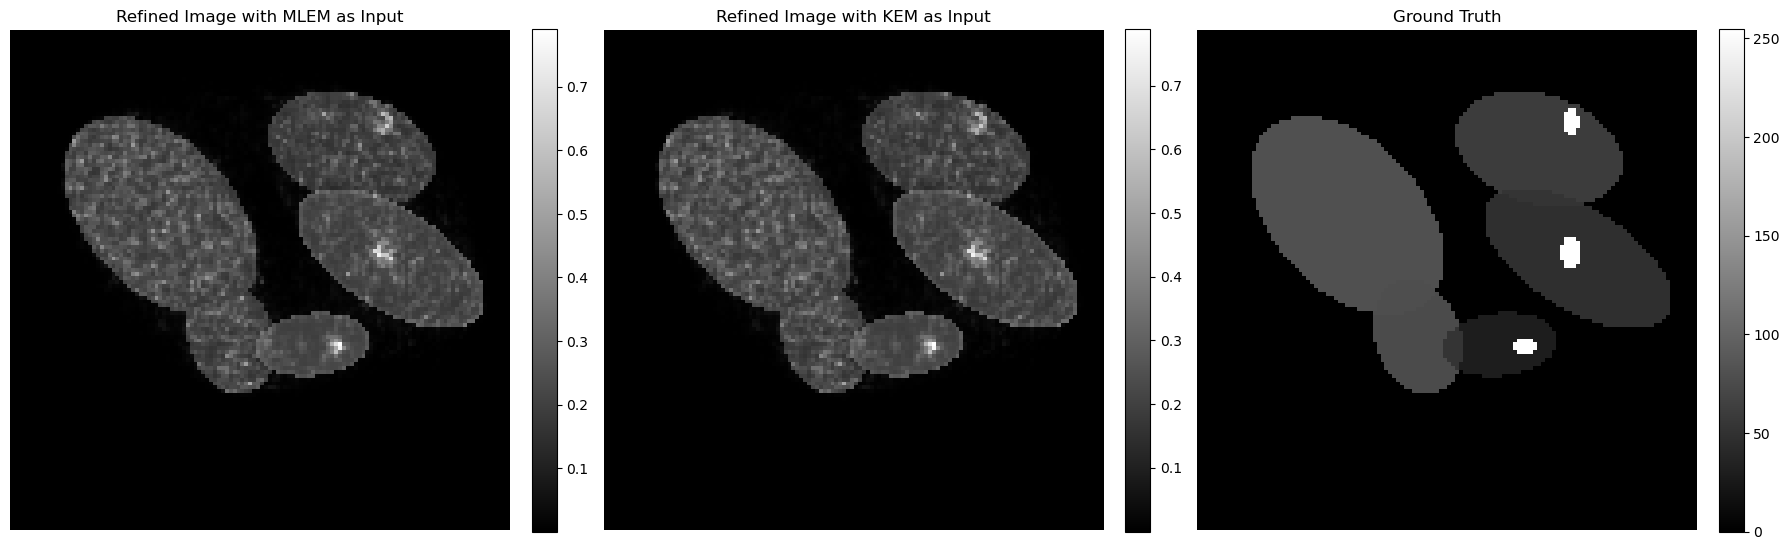

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im1 = axes[0].imshow(dip_with_mlem, cmap='gray')
axes[0].set_title("Refined Image with MLEM as Input")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(refined_image_mse_4, cmap='gray')
axes[1].set_title("Refined Image with KEM as Input")
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im3 = axes[2].imshow(ground_truth, cmap='gray')
axes[2].set_title("Ground Truth")
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

## With an additional layer to recrecover the intensity values
**This is not working yet**

In [33]:
# new try with additional Layer for intensity recovery 
class UNetWithCorrection(nn.Module):
    def __init__(self):
        super(UNetWithCorrection, self).__init__()
        self.unet = skip(2, 1,  # Input: (KEM + CT Prior), Output: Reconstruction
            num_channels_down=[16, 32, 64, 128, 128],
            num_channels_up=[16, 32, 64, 128, 128],
            num_channels_skip=[4, 4, 4, 4, 4],
            upsample_mode='bilinear',
            need_sigmoid=True, 
            need_bias=True,
            pad='reflection', 
            act_fun='LeakyReLU')

        # Extra intensity correction layer
        self.intensity_correction = nn.Conv2d(1, 1, kernel_size=1, stride=1)

    def forward(self, x):
        dip_output = self.unet(x)
        intensity_map = self.intensity_correction(dip_output)  # Learnable rescaling
        return dip_output, intensity_map


def run_dip_kem_refinement(kem_image, ct_image, angles, filter_method="bayesian", num_iterations=1000, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert images to tensors
    kem_recon = torch.tensor(kem_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    ct_prior = torch.tensor(ct_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Normalize images
    kem_recon = (kem_recon - kem_recon.min()) / (kem_recon.max() - kem_recon.min())
    ct_prior = (ct_prior - ct_prior.min()) / (ct_prior.max() - ct_prior.min())

    # Resize CT prior if needed
    if ct_prior.shape != kem_recon.shape:
        ct_prior = F.interpolate(ct_prior, size=kem_recon.shape[2:], mode="bilinear", align_corners=False)

    # Initialize Model
    net = UNetWithCorrection().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    ssim_loss_fn = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    # DIP Input: Concatenate KEM + CT Prior
    dip_input = torch.cat((kem_recon, ct_prior), dim=1)

    # Training Loop
    for i in range(num_iterations):
        optimizer.zero_grad()

        # Forward pass
        dip_output, intensity_map = net(dip_input)
        final_pet_image = dip_output * (1 + intensity_map)  # Apply learned correction

        # Compute Losses
        fidelity_loss = mse_loss(dip_output, kem_recon)  # KEM fidelity
        ssim_loss = 1 - ssim_loss_fn(dip_output, ct_prior)  # Structure from CT
        tumor_loss = mse_loss(final_pet_image, kem_recon)  # Match KEM
        tv_loss = total_variation_loss(final_pet_image)
        edge_loss = gradient_difference_loss(dip_output, ct_prior)

        # Combined Loss
        total_loss = 1.2 * fidelity_loss + 0.2 * ssim_loss + 0.5 * tumor_loss + 0.05 * tv_loss + 0.3 * edge_loss

        # Backpropagation
        total_loss.backward()
        optimizer.step()

        # Print loss every 100 iterations
        if i % 100 == 0:
            print(f"Iteration {i}/{num_iterations} - Loss: {total_loss.item():.6f}")

    final_image = final_pet_image.squeeze().detach().cpu().numpy()

    return final_image


refined_image2 = run_dip_kem_refinement(only_kem_result, ct_prior, angles)

Iteration 0/1000 - Loss: 0.703792
Iteration 100/1000 - Loss: 0.291135
Iteration 200/1000 - Loss: 0.215549
Iteration 300/1000 - Loss: 0.194370
Iteration 400/1000 - Loss: 0.167184
Iteration 500/1000 - Loss: 0.112032
Iteration 600/1000 - Loss: 0.067178
Iteration 700/1000 - Loss: 0.062734
Iteration 800/1000 - Loss: 0.061434
Iteration 900/1000 - Loss: 0.060539


**Plot the results**

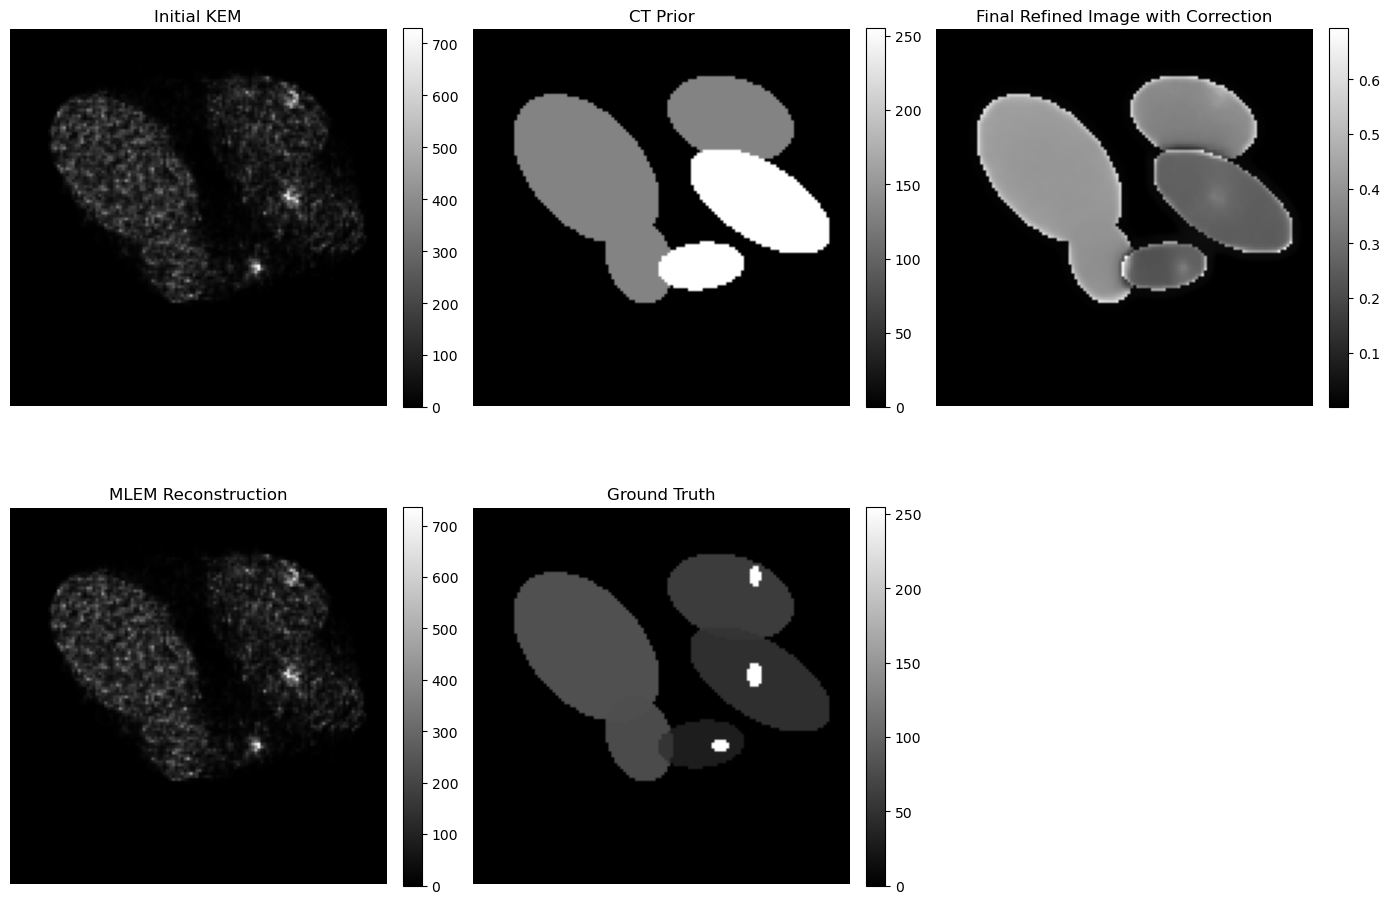

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

im1 = axes[0, 0].imshow(only_kem_result, cmap="gray")
axes[0, 0].set_title("Initial KEM")
axes[0, 0].axis("off")
fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)

im2 = axes[0, 1].imshow(ct_prior, cmap="gray")
axes[0, 1].set_title("CT Prior")
axes[0, 1].axis("off")
fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)

im3 = axes[0, 2].imshow(refined_image2, cmap="gray")
axes[0, 2].set_title("Final Refined Image with Correction")
axes[0, 2].axis("off")
fig.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)

im4 = axes[1, 0].imshow(mlem_reconstructed, cmap="gray")
axes[1, 0].set_title("MLEM Reconstruction")
axes[1, 0].axis("off")
fig.colorbar(im4, ax=axes[1, 0], fraction=0.046, pad=0.04)

im5 = axes[1, 1].imshow(ground_truth, cmap="gray")
axes[1, 1].set_title("Ground Truth")
axes[1, 1].axis("off")
fig.colorbar(im5, ax=axes[1, 1], fraction=0.046, pad=0.04)

fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

## Combination of KEM and DIP using edge detection
**Alternative approach that is not working 100% but is kept for documentation**

In [31]:

# Apply Bilateral Filter
def apply_bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
    """
    Applies bilateral filtering to smooth CT edges while preserving sharp structures.
    
    Parameters:
    - image: NumPy array of the image.
    - d: Diameter of each pixel neighborhood.
    - sigma_color: Filter sigma in the color space.
    - sigma_space: Filter sigma in the coordinate space.
    
    Returns:
    - Filtered image as a NumPy array.
    """
    # Normalize to 0-255 for better filtering
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0,1]
    image = (image * 255).astype(np.uint8)  # Convert to 8-bit

    # Apply bilateral filtering
    filtered = cv2.bilateralFilter(image, d=d, sigmaColor=sigma_color, sigmaSpace=sigma_space)

    # Convert back to float
    filtered = filtered.astype(np.float32) / 255.0
    return filtered


# DIP Model with CT Prior
class DeepDIP_with_CT(nn.Module):
    def __init__(self):
        super(DeepDIP_with_CT, self).__init__()

        # DIP network (KEM as input)
        self.net = skip(
            1,  # Only KEM as input
            1,  # Output single-channel image
            num_channels_down=[32, 64, 128, 256, 256],  
            num_channels_up=[32, 64, 128, 256, 256],
            num_channels_skip=[8, 8, 8, 8, 8],  
            upsample_mode='bilinear',
            need_sigmoid=True, 
            need_bias=True,
            pad='reflection', 
            act_fun='LeakyReLU'
        )

        # Edge extraction for CT prior
        self.sobel_x = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.sobel_y = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        sobel_x_kernel = torch.tensor([[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]], dtype=torch.float32).unsqueeze(0)
        sobel_y_kernel = torch.tensor([[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]], dtype=torch.float32).unsqueeze(0)
        self.sobel_x.weight = nn.Parameter(sobel_x_kernel, requires_grad=False)
        self.sobel_y.weight = nn.Parameter(sobel_y_kernel, requires_grad=False)

    def forward(self, kem, ct_prior): 
        # Extract edges from CT using Sobel filters
        ct_edges_x = self.sobel_x(ct_prior)
        ct_edges_y = self.sobel_y(ct_prior)
        ct_edges = torch.sqrt(ct_edges_x ** 2 + ct_edges_y ** 2)  # Edge magnitude

        # Apply a threshold to filter weak edges
        edge_threshold = 0.5  
        ct_edges = torch.where(ct_edges > edge_threshold, ct_edges, torch.tensor(0.0).to(ct_edges.device))

        # Convert to NumPy, Apply Bilateral Filtering, and Convert Back to Tensor
        ct_edges_np = ct_edges.squeeze().cpu().numpy()
        ct_edges_filtered = apply_bilateral_filter(ct_edges_np)  # Smooth edges
        ct_edges_filtered = torch.tensor(ct_edges_filtered, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(ct_edges.device)

        # Normalize edges to avoid overly bright areas
        ct_edges_filtered = (ct_edges_filtered - ct_edges_filtered.min()) / (ct_edges_filtered.max() - ct_edges_filtered.min() + 1e-6)  

        # Pass through DIP network
        output = self.net(kem)

        # Learnable Weight Map for CT Edge Contribution
        weight_map = torch.sigmoid(output)  # Generates values between 0 and 1
        refined_output = output + 2 * weight_map * ct_edges_filtered  # Increase weight factor

        return refined_output


# Gradient Difference Loss
def gradient_difference_loss(output, reference):
    grad_output_x = output[:, :, :-1, :] - output[:, :, 1:, :]
    grad_output_y = output[:, :, :, :-1] - output[:, :, :, 1:]

    grad_ref_x = reference[:, :, :-1, :] - reference[:, :, 1:, :]
    grad_ref_y = reference[:, :, :, :-1] - reference[:, :, :, 1:]

    loss_x = F.l1_loss(grad_output_x, grad_ref_x)
    loss_y = F.l1_loss(grad_output_y, grad_ref_y)

    return loss_x + loss_y


# Main Model Function
def model2(kem_image, ct_image, angles, filter_method="bayesian"):
    # Ensure device compatibility
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    kem_recon = torch.tensor(kem_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    ct_prior = torch.tensor(ct_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Normalize
    kem_recon = (kem_recon - kem_recon.min()) / (kem_recon.max() - kem_recon.min())
    ct_prior = (ct_prior - ct_prior.min()) / (ct_prior.max() - ct_prior.min())

    # Resize CT to match KEM
    if ct_prior.shape != kem_recon.shape:
        ct_prior = F.interpolate(ct_prior, size=kem_recon.shape[2:], mode="bilinear", align_corners=False)

    # Initialize model
    dip_model = DeepDIP_with_CT().to(device)
    optimizer = optim.Adam(dip_model.parameters(), lr=0.001)
    mse_loss = nn.MSELoss()

    # Training loop
    num_iterations = 1000
    for i in range(num_iterations):
        optimizer.zero_grad()

        # Forward pass
        dip_output = dip_model(kem_recon, ct_prior)

        # Compute losses
        fidelity_loss = mse_loss(dip_output, kem_recon)  # Keep PET features
        ssim_loss = 1 - ssim(dip_output.squeeze().detach().cpu().numpy(), ct_prior.squeeze().detach().cpu().numpy(), data_range=1.0)
        edge_loss = gradient_difference_loss(dip_output, ct_prior)  # Edge preservation

        # Total loss (adjust weights)
        total_loss = fidelity_loss + 0.2 * ssim_loss + 0.3 * edge_loss

        total_loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(f"Iteration {i}/{num_iterations}, Loss: {total_loss.item()}")

    # Get final refined image
    final_image = dip_output.squeeze().detach().cpu().numpy()

    return final_image


refined_image3 = model2(only_kem_result, ct_prior, angles)

Iteration 0/1000, Loss: 0.5895942449569702
Iteration 50/1000, Loss: 0.325689435005188
Iteration 100/1000, Loss: 0.26817572116851807
Iteration 150/1000, Loss: 0.23867449164390564
Iteration 200/1000, Loss: 0.22679367661476135
Iteration 250/1000, Loss: 0.22100596129894257
Iteration 300/1000, Loss: 0.21775858104228973
Iteration 350/1000, Loss: 0.2156185656785965
Iteration 400/1000, Loss: 0.2145581990480423
Iteration 450/1000, Loss: 0.21334527432918549
Iteration 500/1000, Loss: 0.21154437959194183
Iteration 550/1000, Loss: 0.21029365062713623
Iteration 600/1000, Loss: 0.20908194780349731
Iteration 650/1000, Loss: 0.2090887427330017
Iteration 700/1000, Loss: 0.2070770561695099
Iteration 750/1000, Loss: 0.20691624283790588
Iteration 800/1000, Loss: 0.20513370633125305
Iteration 850/1000, Loss: 0.2026158720254898
Iteration 900/1000, Loss: 0.20249655842781067
Iteration 950/1000, Loss: 0.2012302279472351


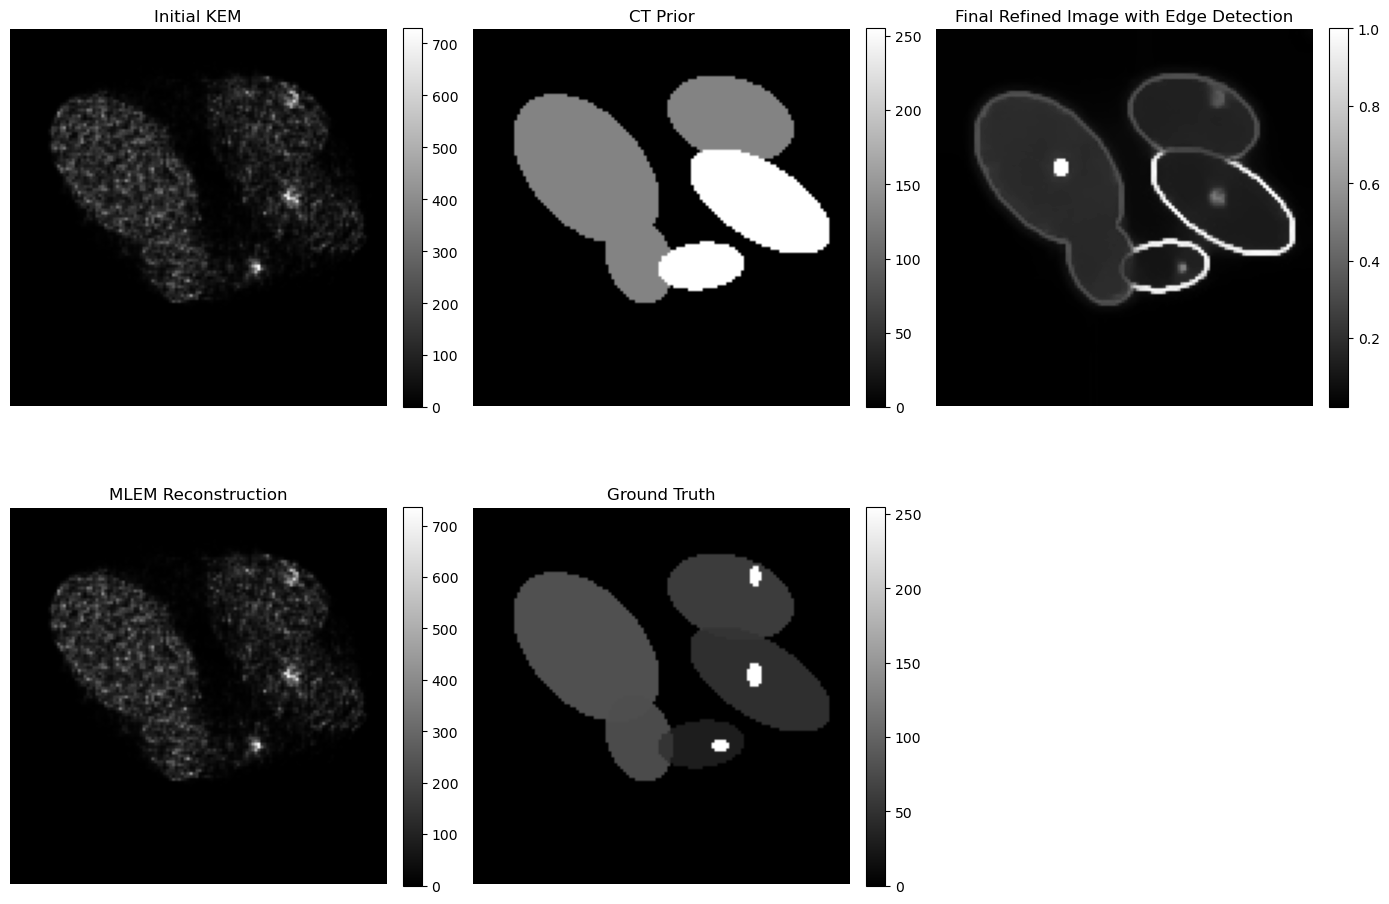

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

im1 = axes[0, 0].imshow(only_kem_result, cmap="gray")
axes[0, 0].set_title("Initial KEM")
axes[0, 0].axis("off")
fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)

im2 = axes[0, 1].imshow(ct_prior, cmap="gray")
axes[0, 1].set_title("CT Prior")
axes[0, 1].axis("off")
fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)

im3 = axes[0, 2].imshow(refined_image3, cmap="gray")
axes[0, 2].set_title("Final Refined Image with Edge Detection")
axes[0, 2].axis("off")
fig.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)

im4 = axes[1, 0].imshow(mlem_reconstructed, cmap="gray")
axes[1, 0].set_title("MLEM Reconstruction")
axes[1, 0].axis("off")
fig.colorbar(im4, ax=axes[1, 0], fraction=0.046, pad=0.04)

im5 = axes[1, 1].imshow(ground_truth, cmap="gray")
axes[1, 1].set_title("Ground Truth")
axes[1, 1].axis("off")
fig.colorbar(im5, ax=axes[1, 1], fraction=0.046, pad=0.04)

fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
#metrics_mlem = evaluate_reconstruction(ground_truth, mlem_reconstructed)
#metrics_model2_reversed_bilateral = evaluate_reconstruction(ground_truth, final_image_bilateral)
#metrics_model2_reversed_anisotropic = evaluate_reconstruction(ground_truth, final_image_anisotropic)
#metrics_model2_reversed_gaussian = evaluate_reconstruction(ground_truth, final_image_gaussian)
#metrics_model2_reversed_bayesian = evaluate_reconstruction(ground_truth, refined_image)

#print("MLEM:")
#print(f"MSE: {metrics_mlem[0]:.4f}, PSNR: {metrics_mlem[1]:.2f}, SSIM: {metrics_mlem[2]:.4f}, RMSE: {metrics_mlem[3]:.4f} \n")

#print("Bilateral Kernel:")
#print(f"MSE: {metrics_model2_reversed_bilateral[0]:.4f}, PSNR: {metrics_model2_reversed_bilateral[1]:.2f}, SSIM: {metrics_model2_reversed_bilateral[2]:.4f}, RMSE: {metrics_model2_reversed_bilateral[3]:.4f} \n")

#print("Anisotropic Kernel:")
#print(f"MSE: {metrics_model2_reversed_anisotropic[0]:.4f}, PSNR: {metrics_model2_reversed_anisotropic[1]:.4f}, SSIM: {metrics_model2_reversed_anisotropic[2]:.4f}, RMSE: {metrics_model2_reversed_anisotropic[3]:.4f} \n")

#print("Gaussian Kernel:")
#print(f"MSE: {metrics_model2_reversed_gaussian[0]:.4f}, PSNR: {metrics_model2_reversed_gaussian[1]:.2f}, SSIM: {metrics_model2_reversed_gaussian[2]:.4f}, RMSE: {metrics_model2_reversed_gaussian[3]:.4f} \n")

#print("Bayesian Kernel:")
#print(f"MSE: {metrics_model2_reversed_bayesian[0]:.4f}, PSNR: {metrics_model2_reversed_bayesian[1]:.2f}, SSIM: {metrics_model2_reversed_bayesian[2]:.4f}, RMSE: {metrics_model2_reversed_bayesian[3]:.4f} \n")